<a href="https://colab.research.google.com/github/kospi-2025/EVT/blob/main/%5Bcode%5D%20LMO_plot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import numpy as np
import pandas as pd

base_url = "https://raw.githubusercontent.com/kospi-2025/EVT/main/"

df = pd.read_csv(base_url + "source_data/" + "ticker_info.csv")
df['id'] = df['id'].astype(str).str.zfill(6)
df['Yahoo_Ticker'] = df['id'] + ".KS"

ticker_to_name = dict(zip(df["Yahoo_Ticker"], df["name"]))
ticker_to_sector = dict(zip(df["Yahoo_Ticker"], df["sector"]))

logDD = pd.read_csv(base_url + "logDD.csv", index_col=0, parse_dates=True)

# LMO

In [6]:
!pip install -q lmoments3
!pip install -q pyextremes

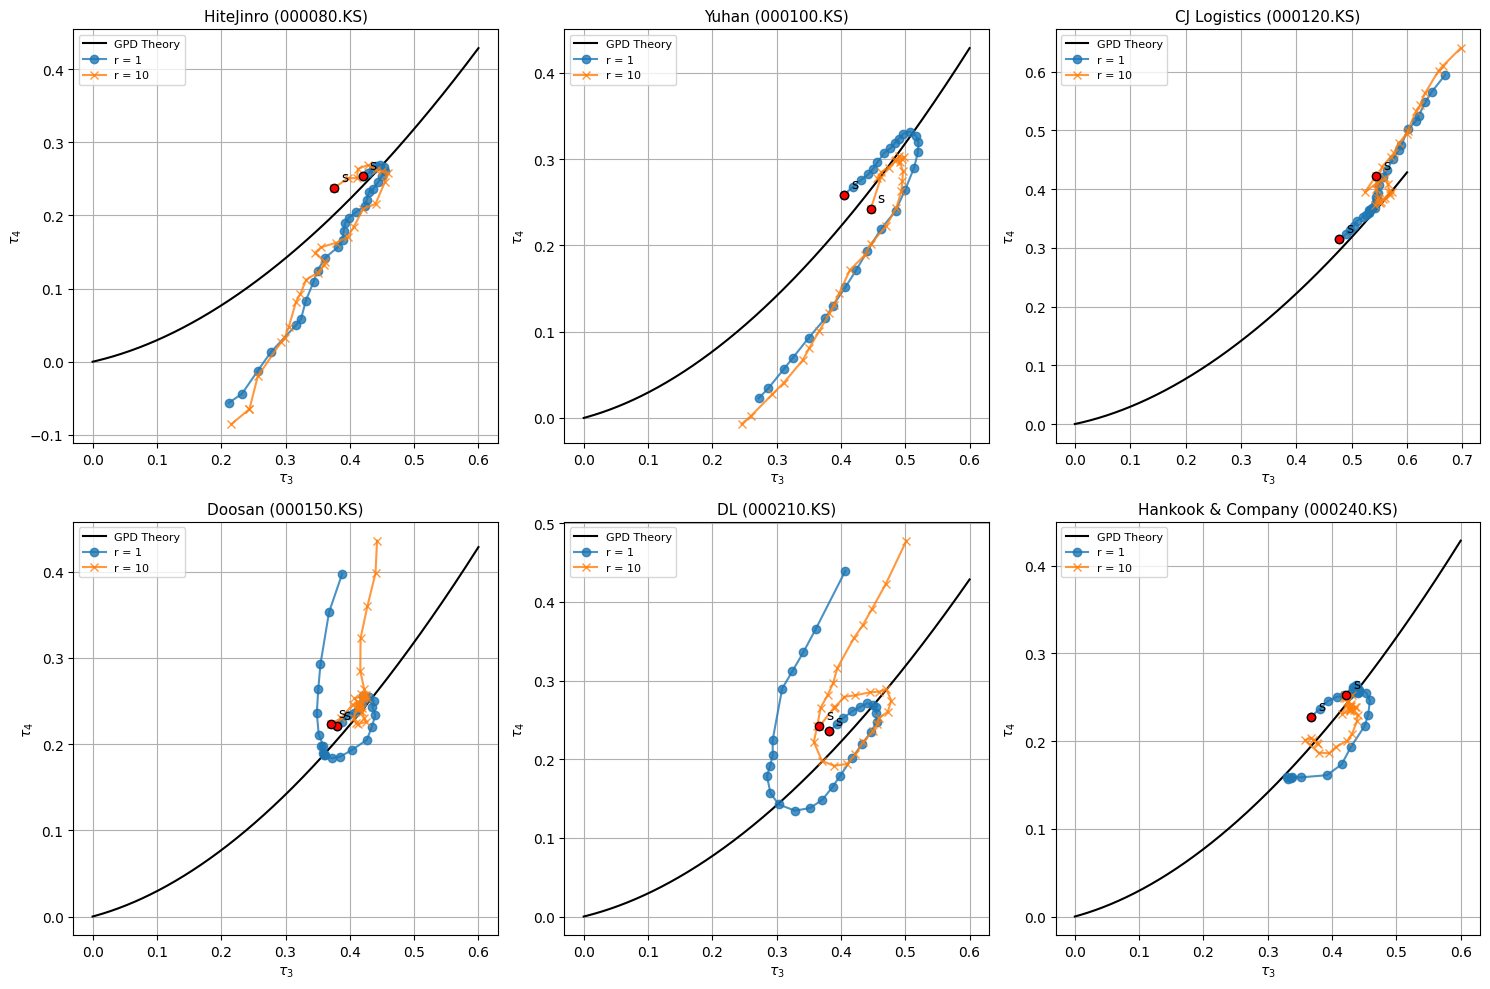

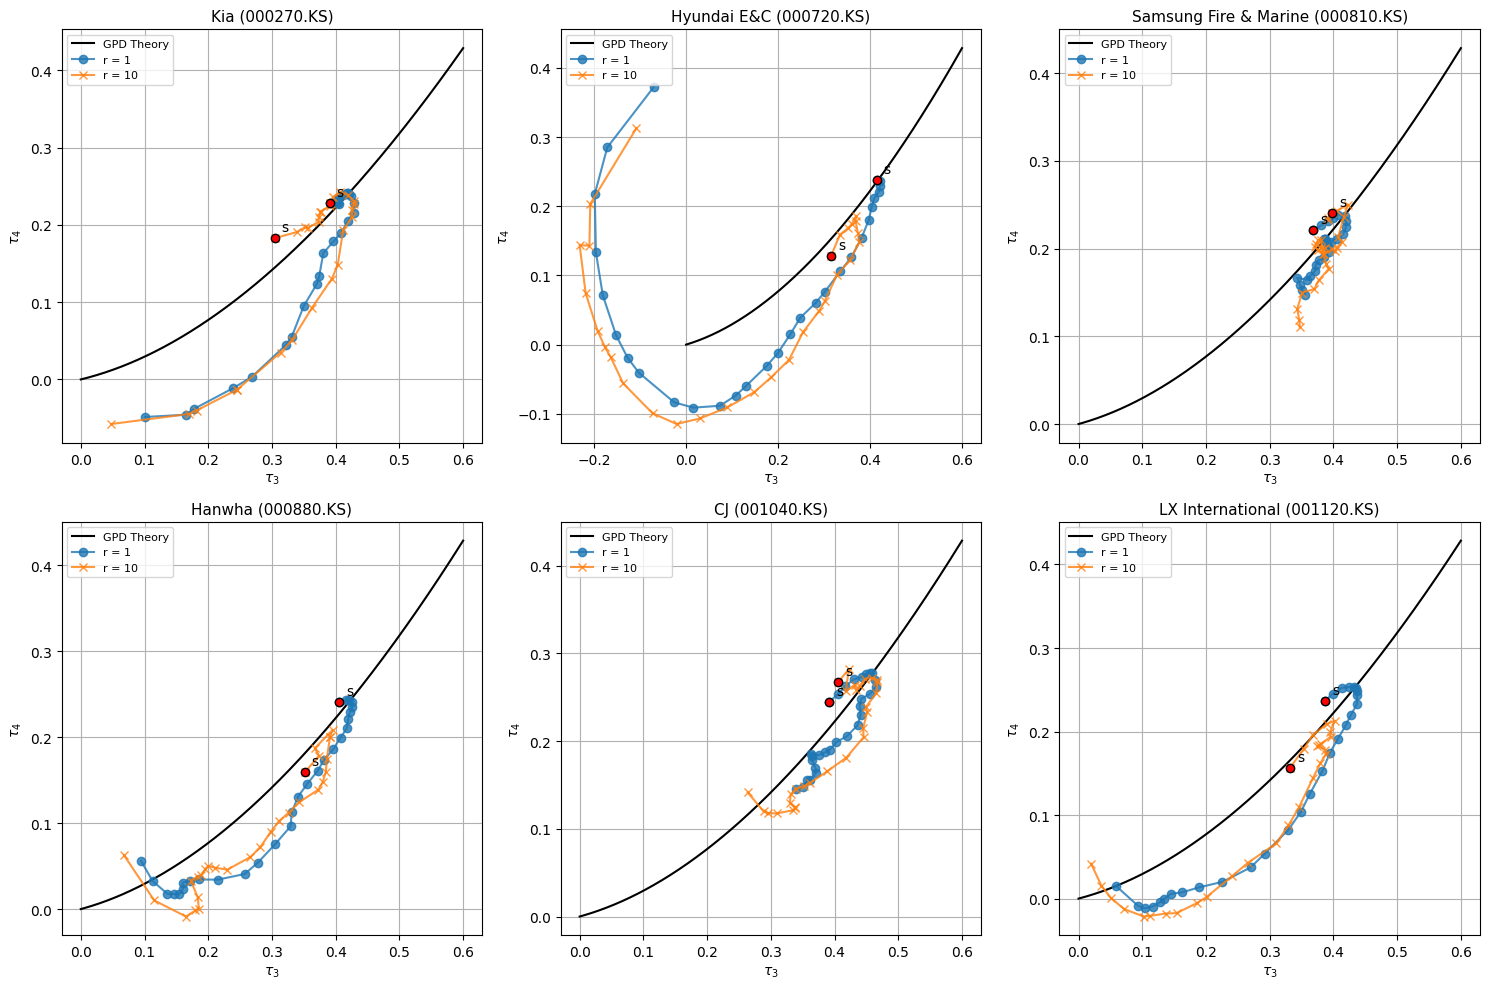

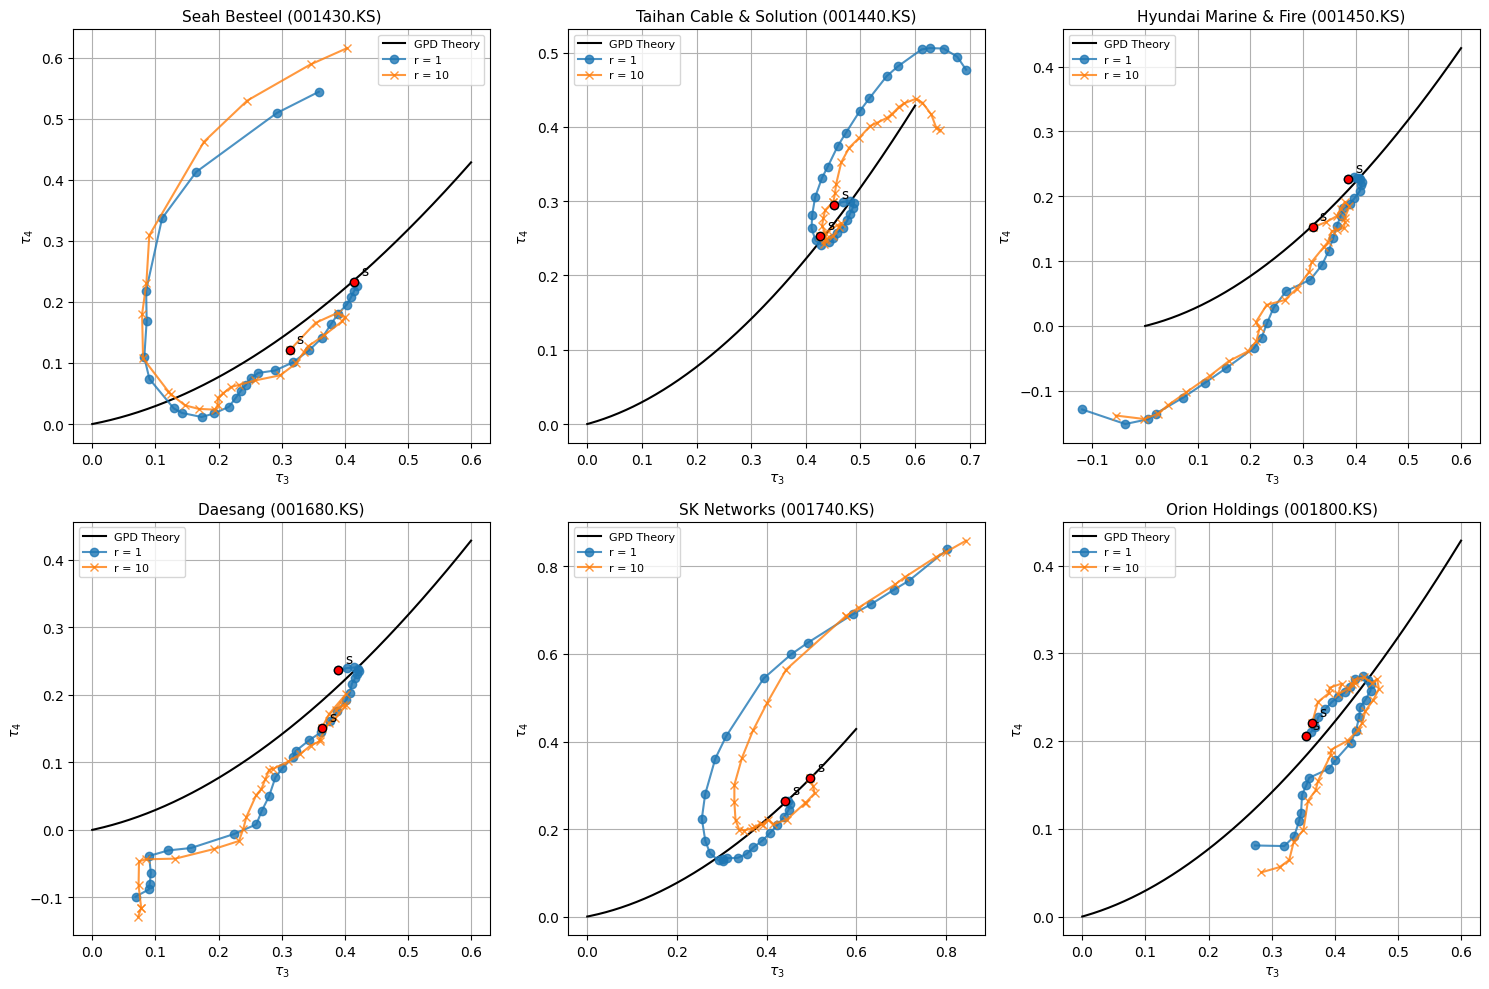

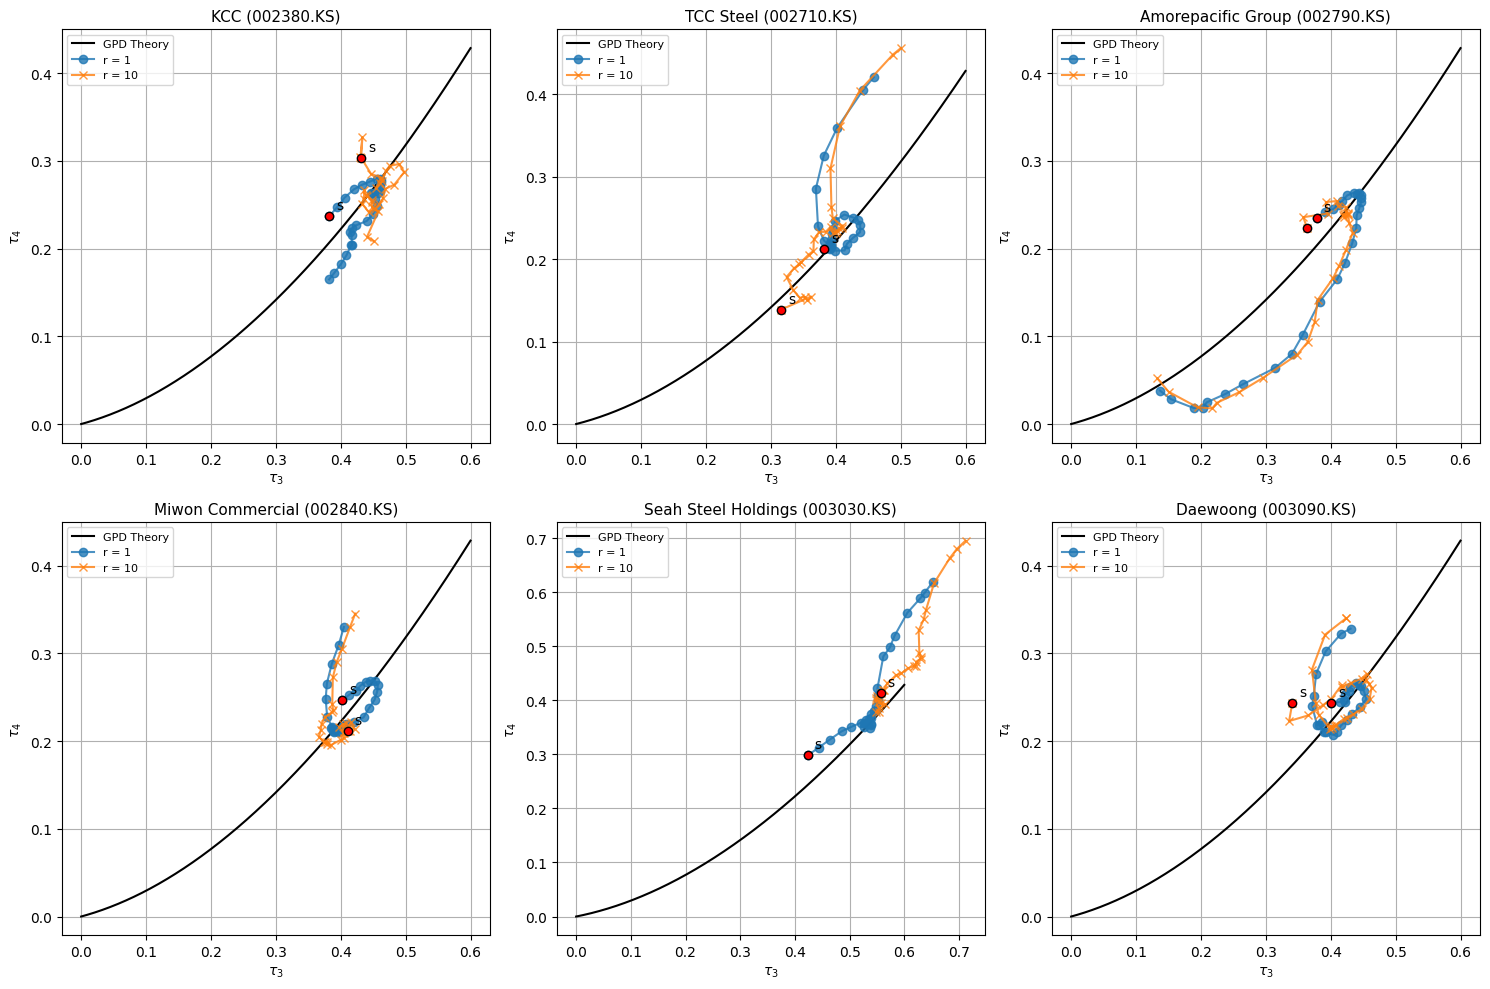

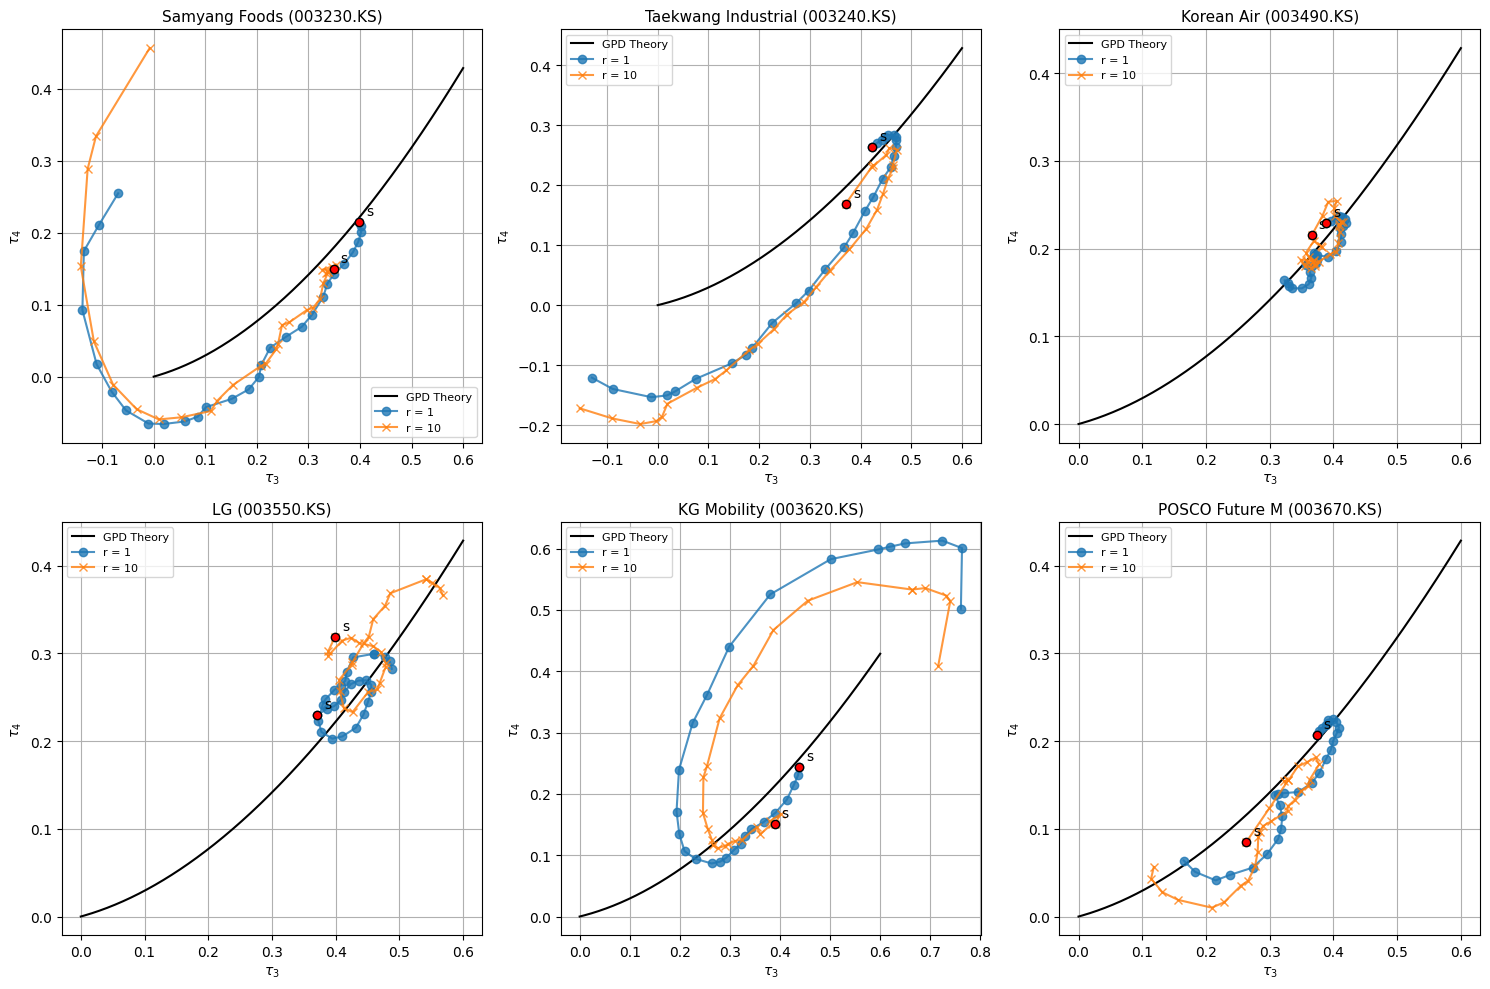

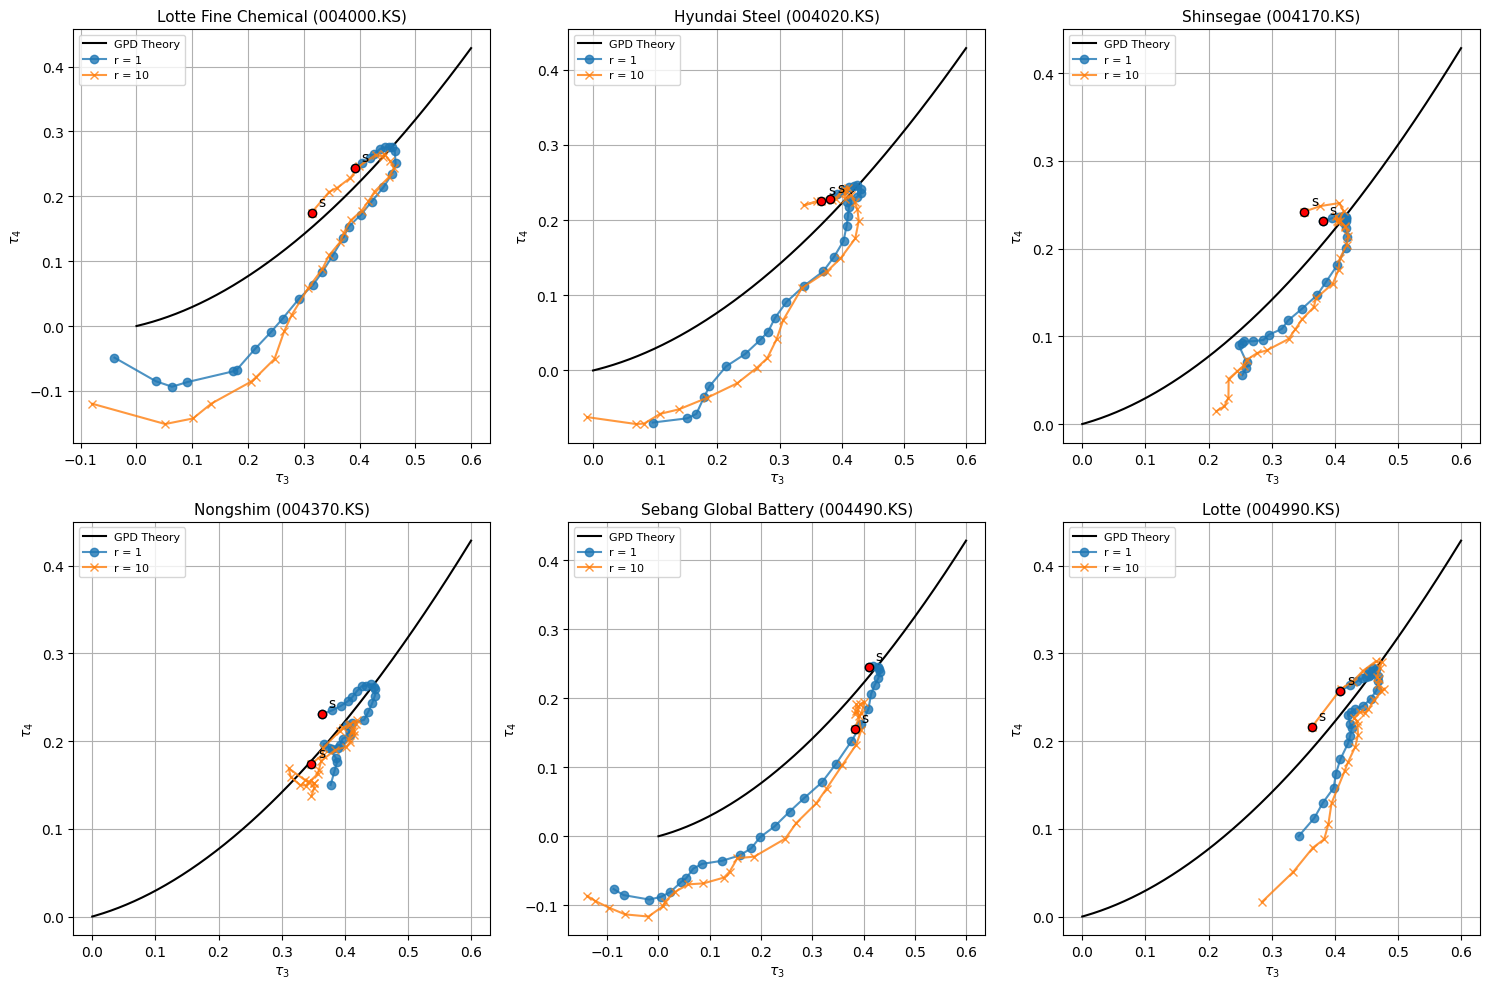

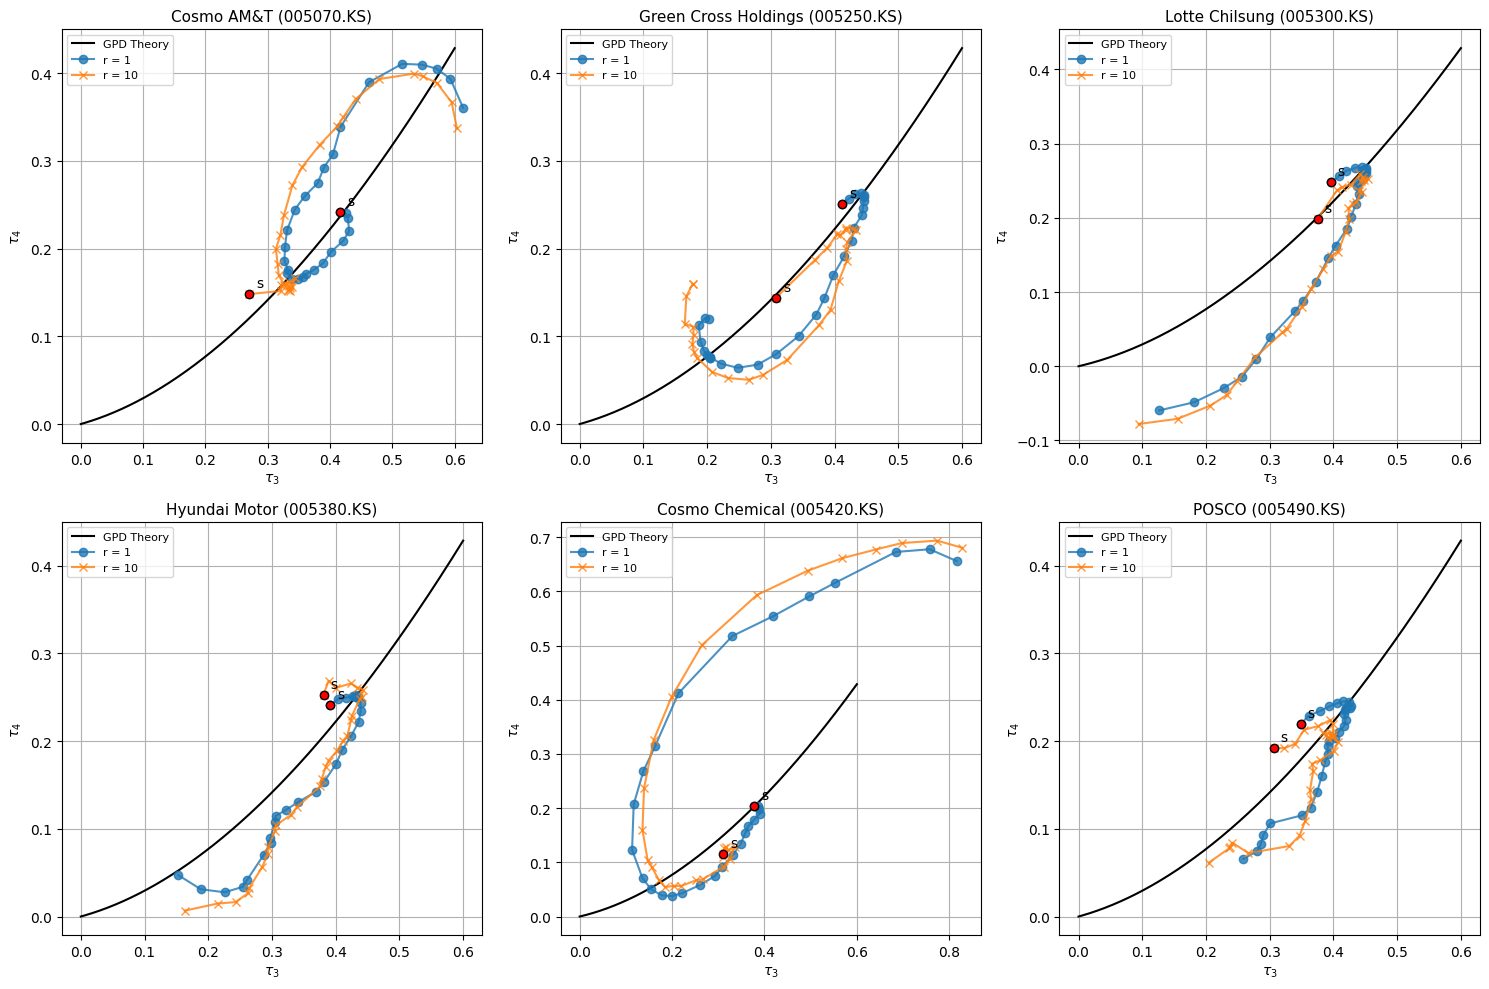

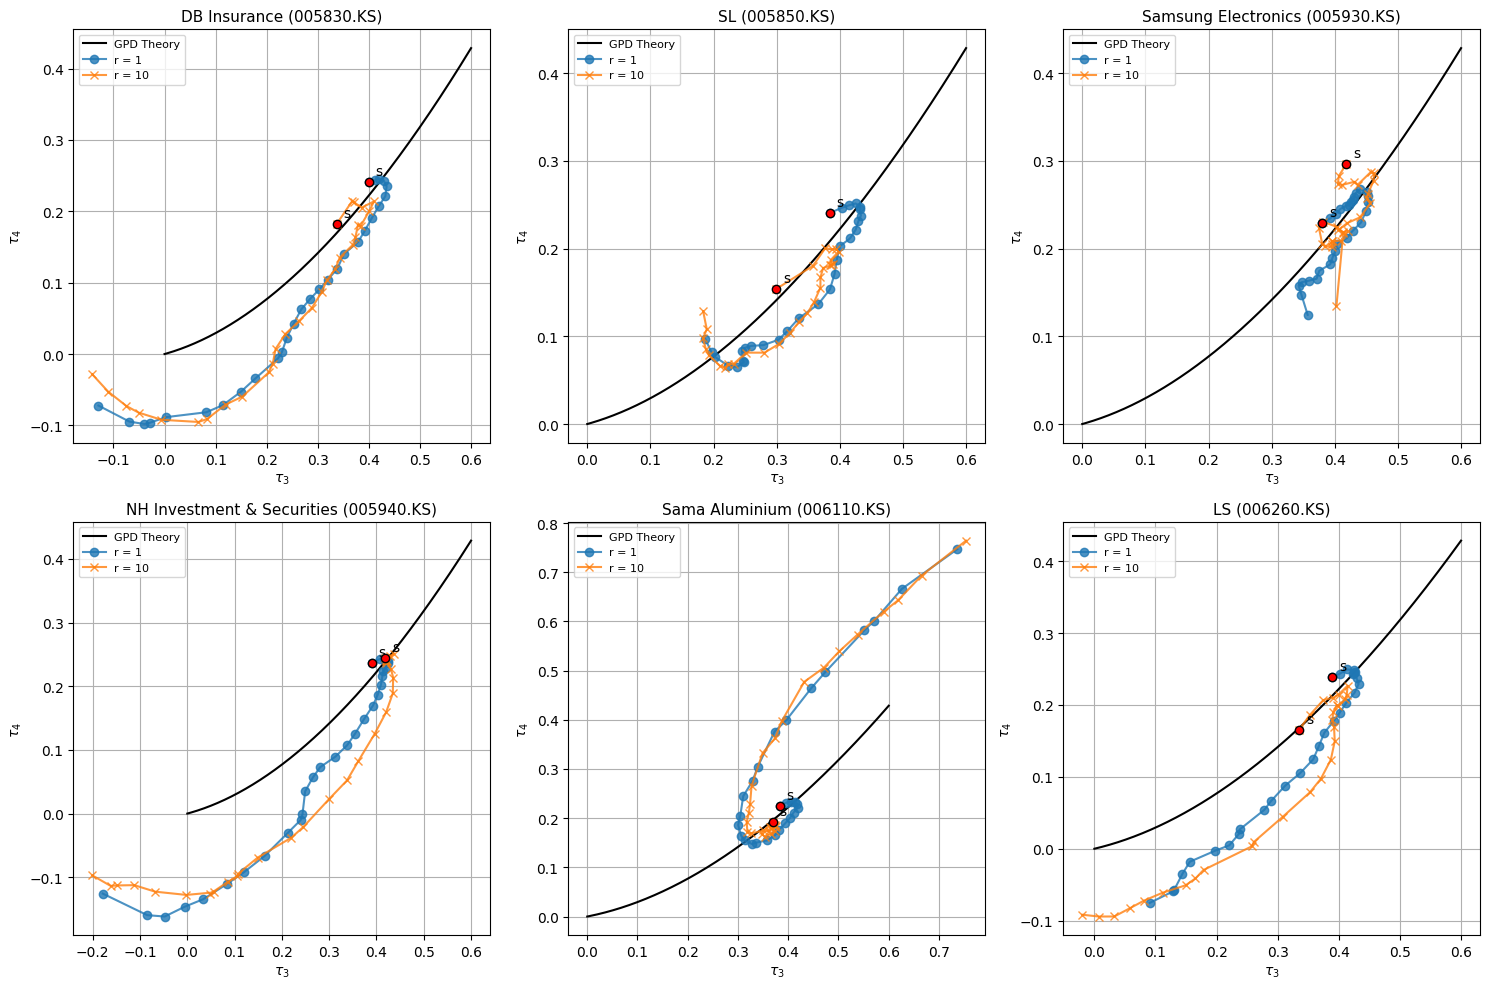

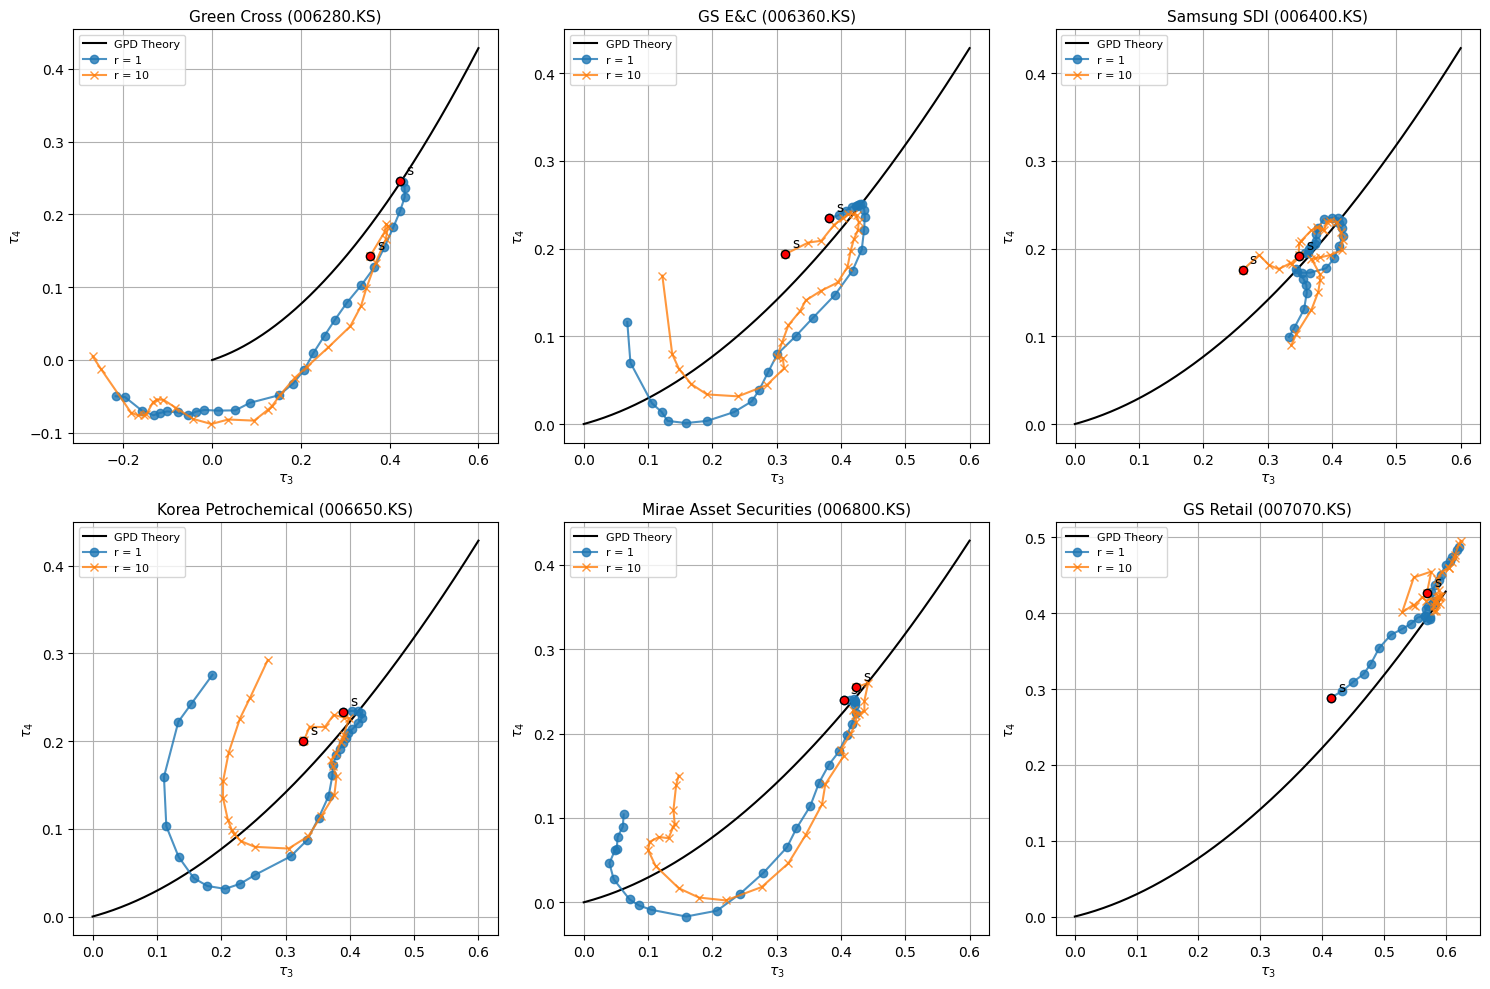

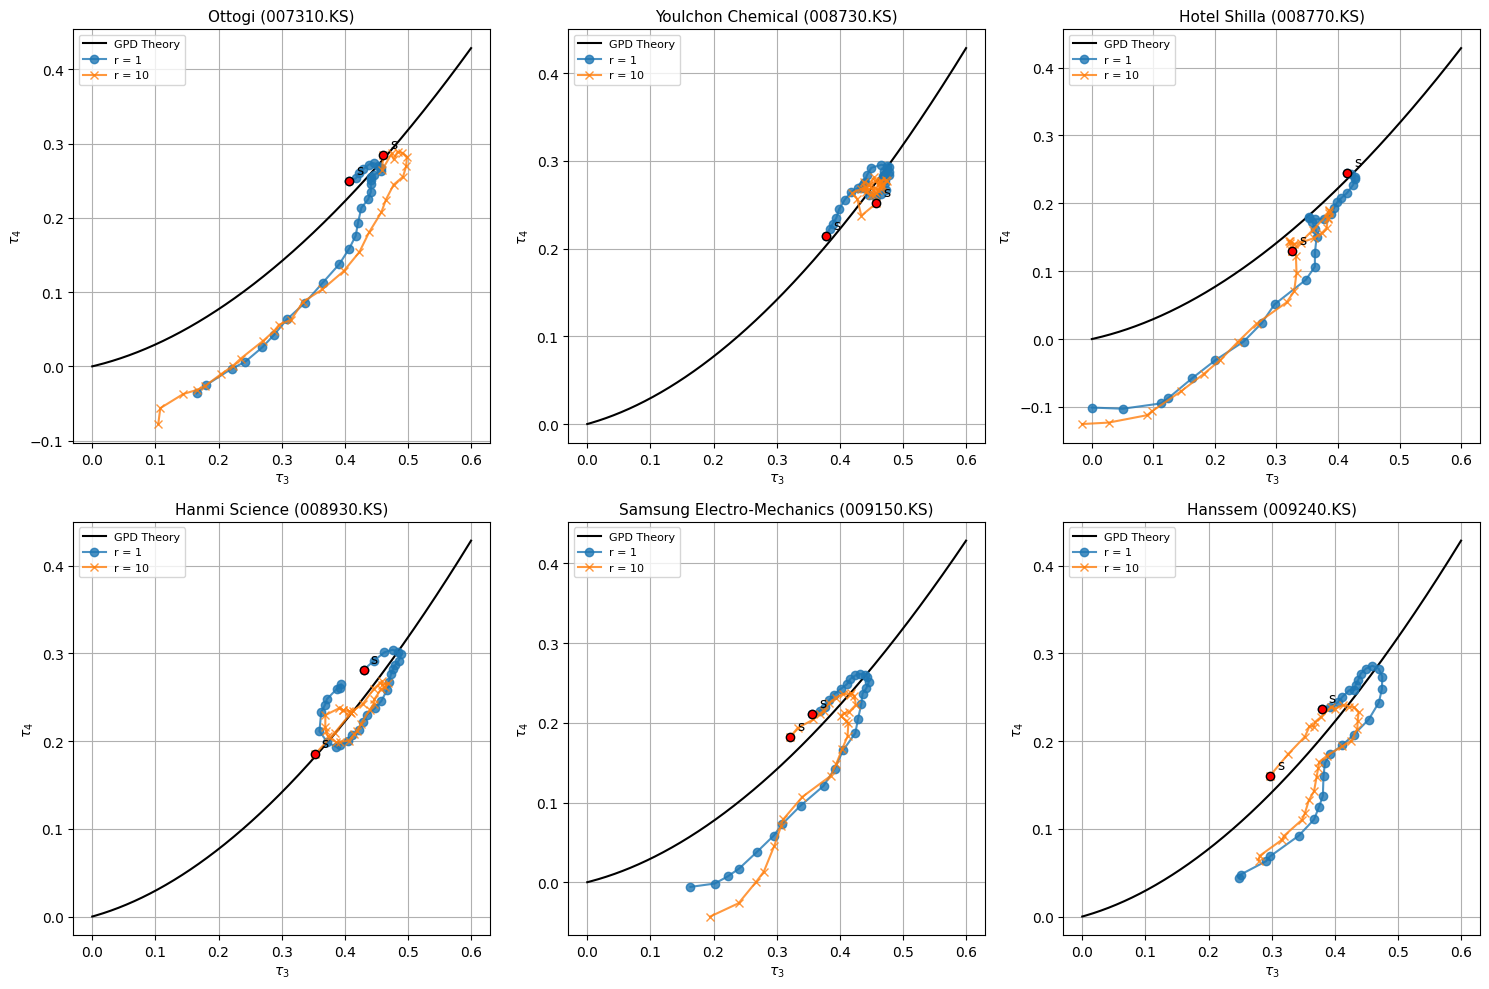

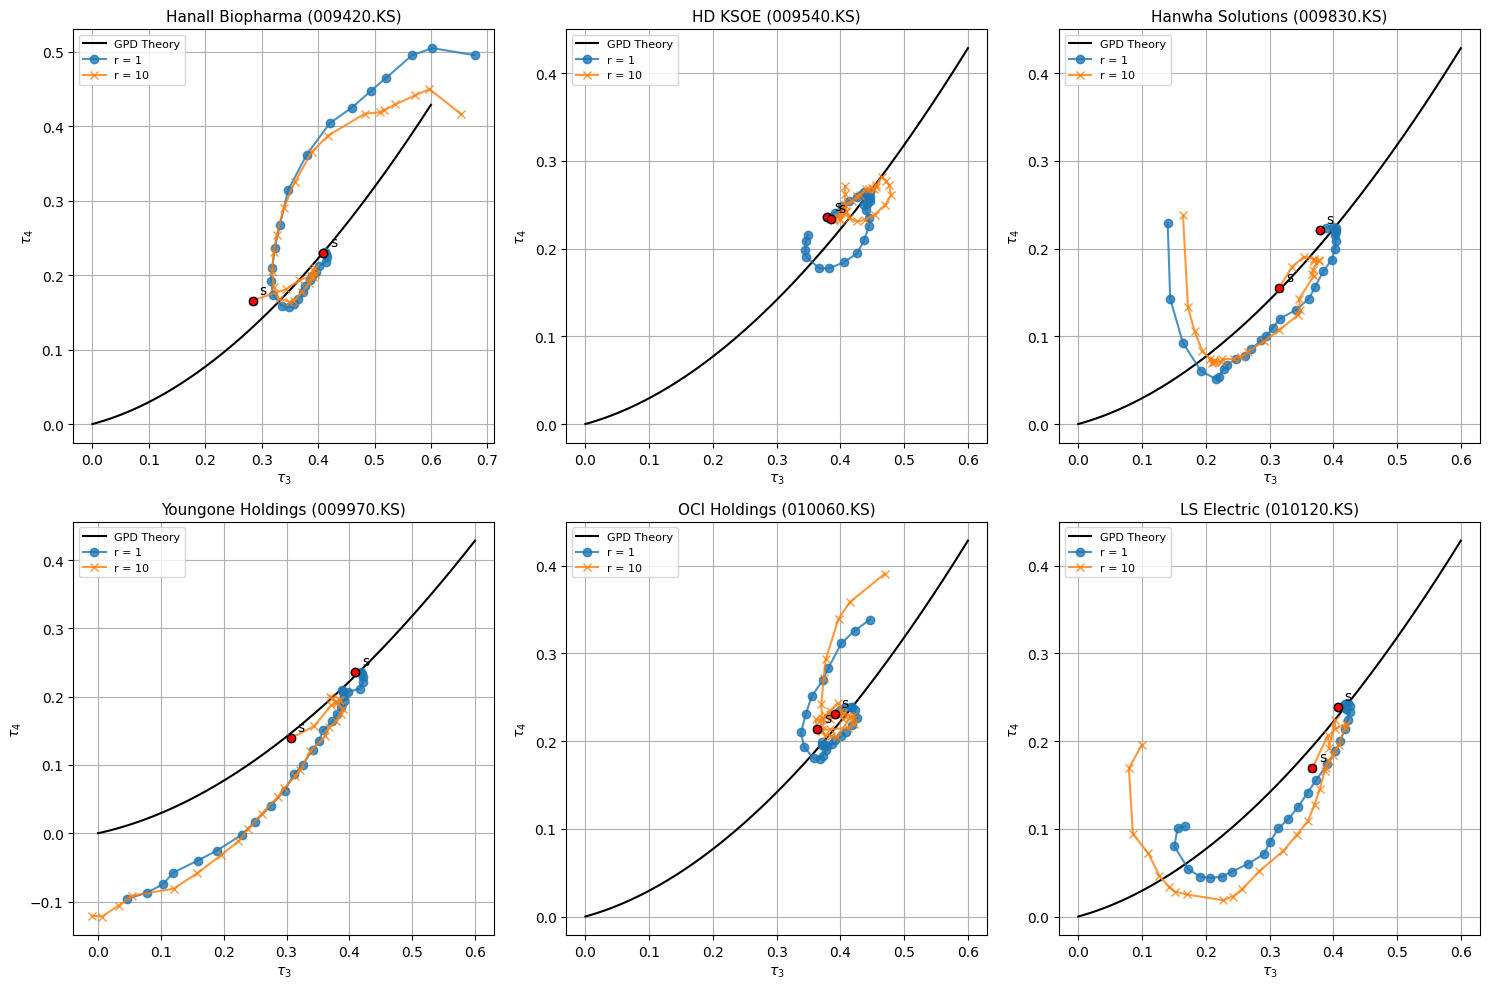

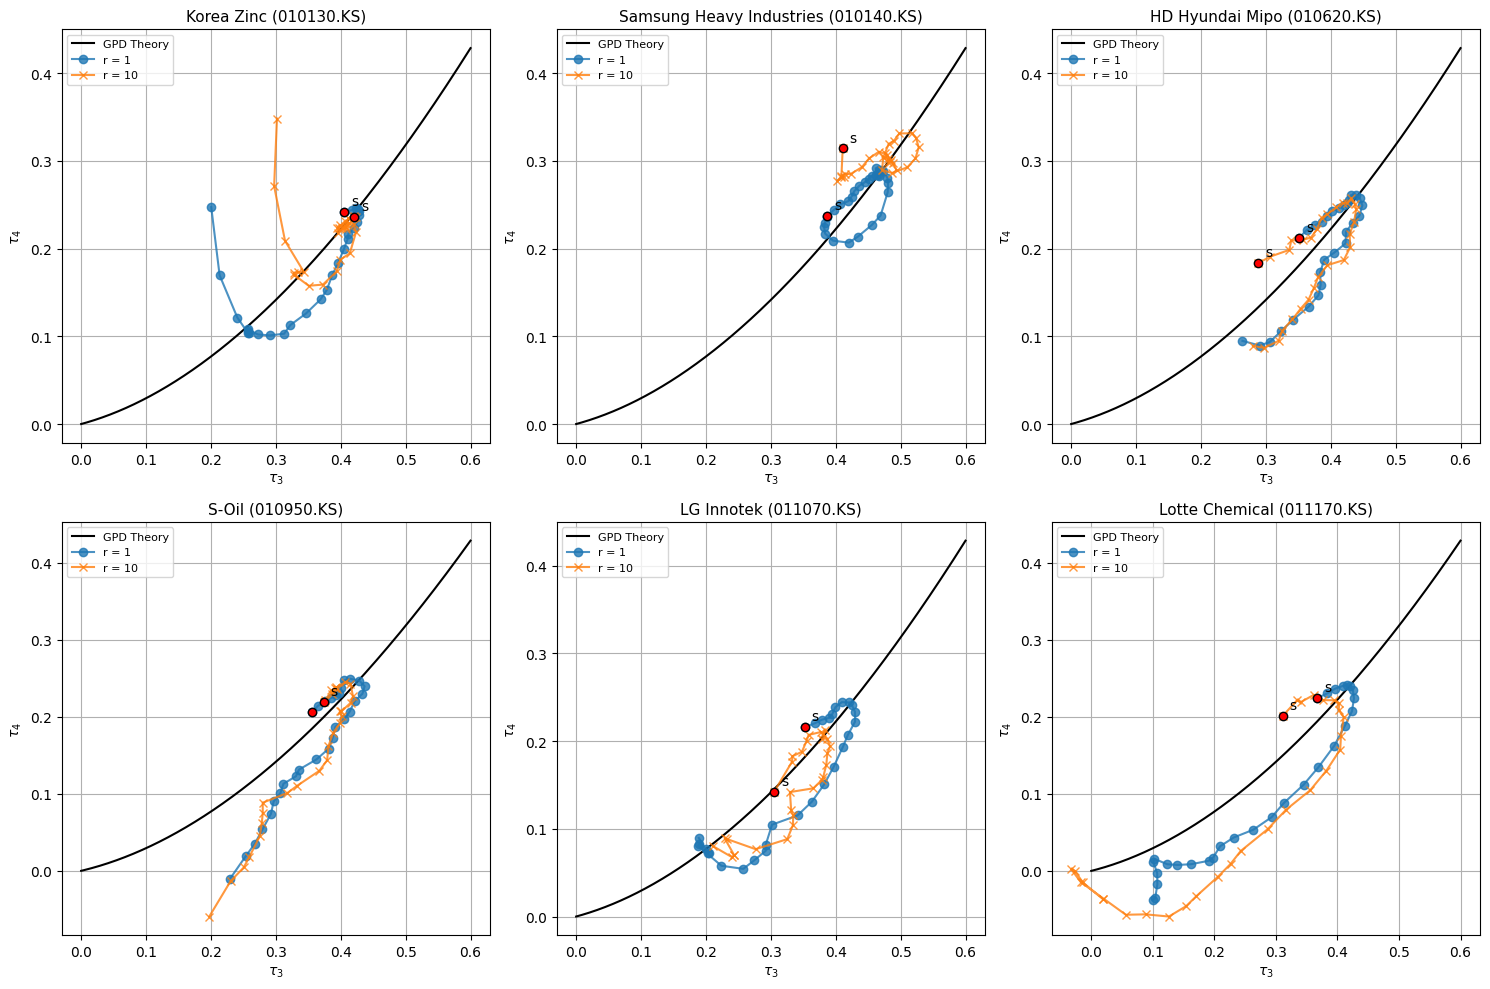

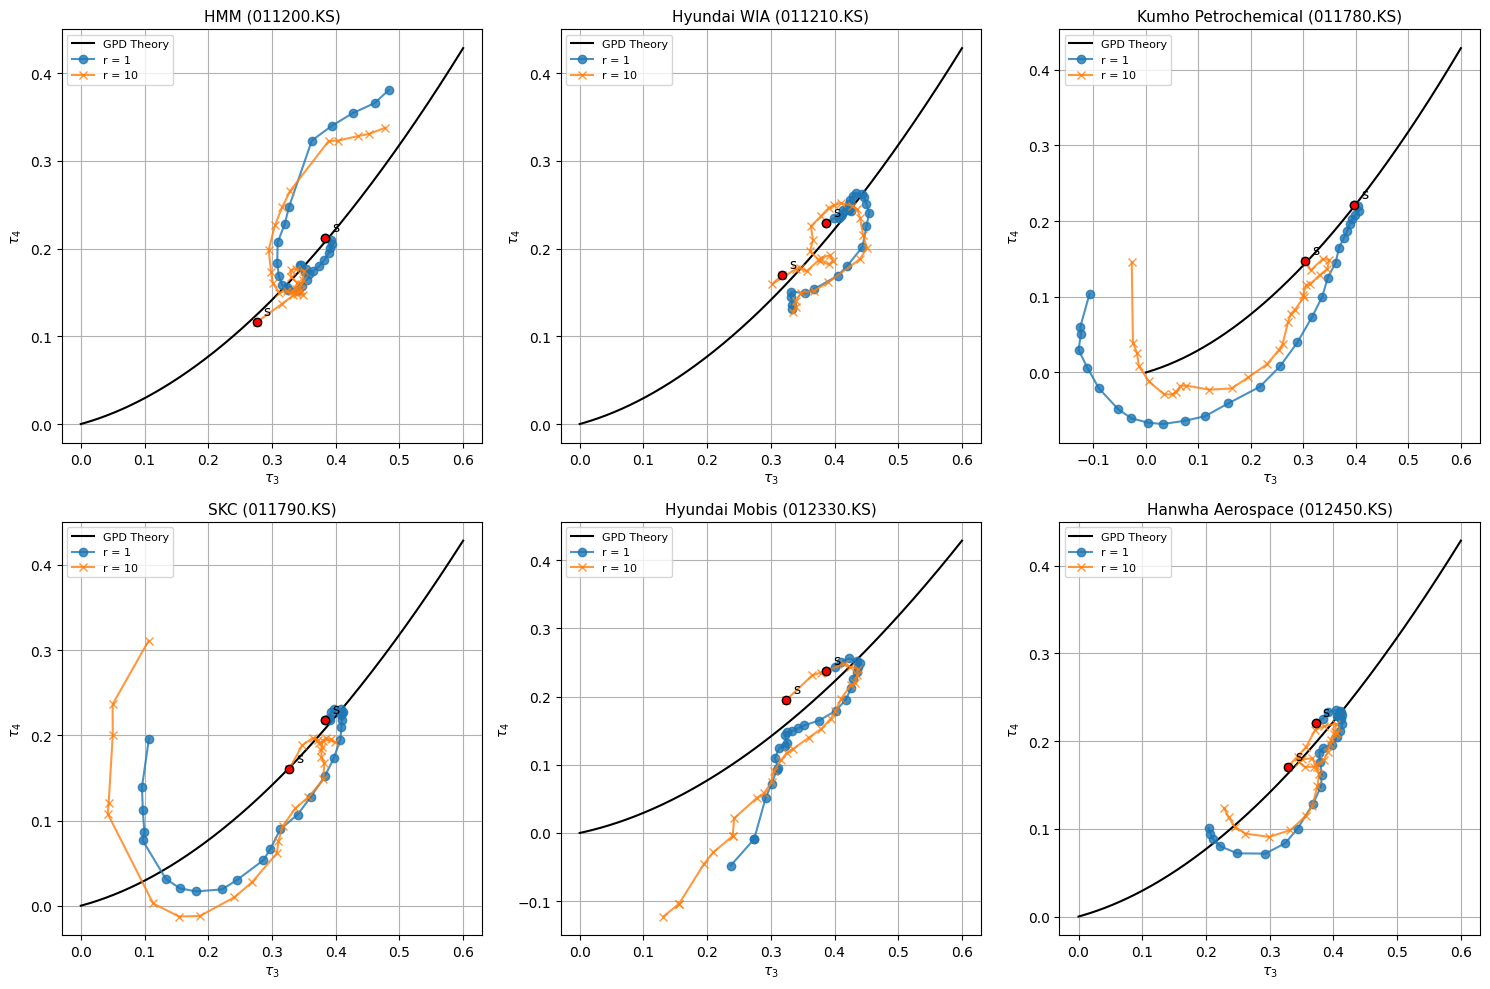

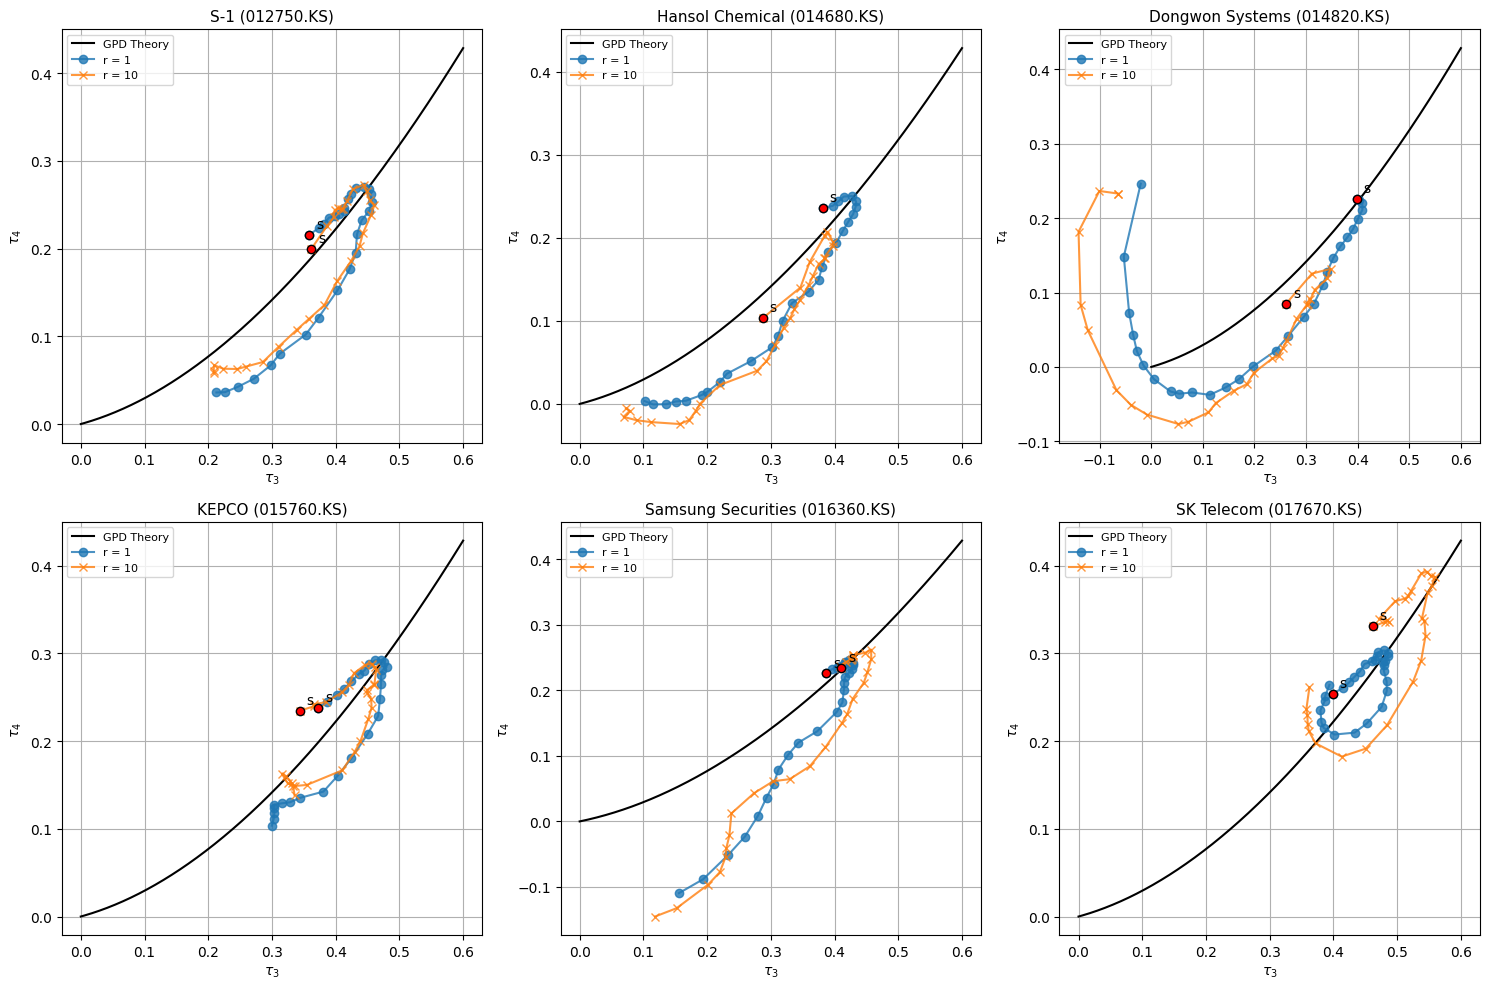

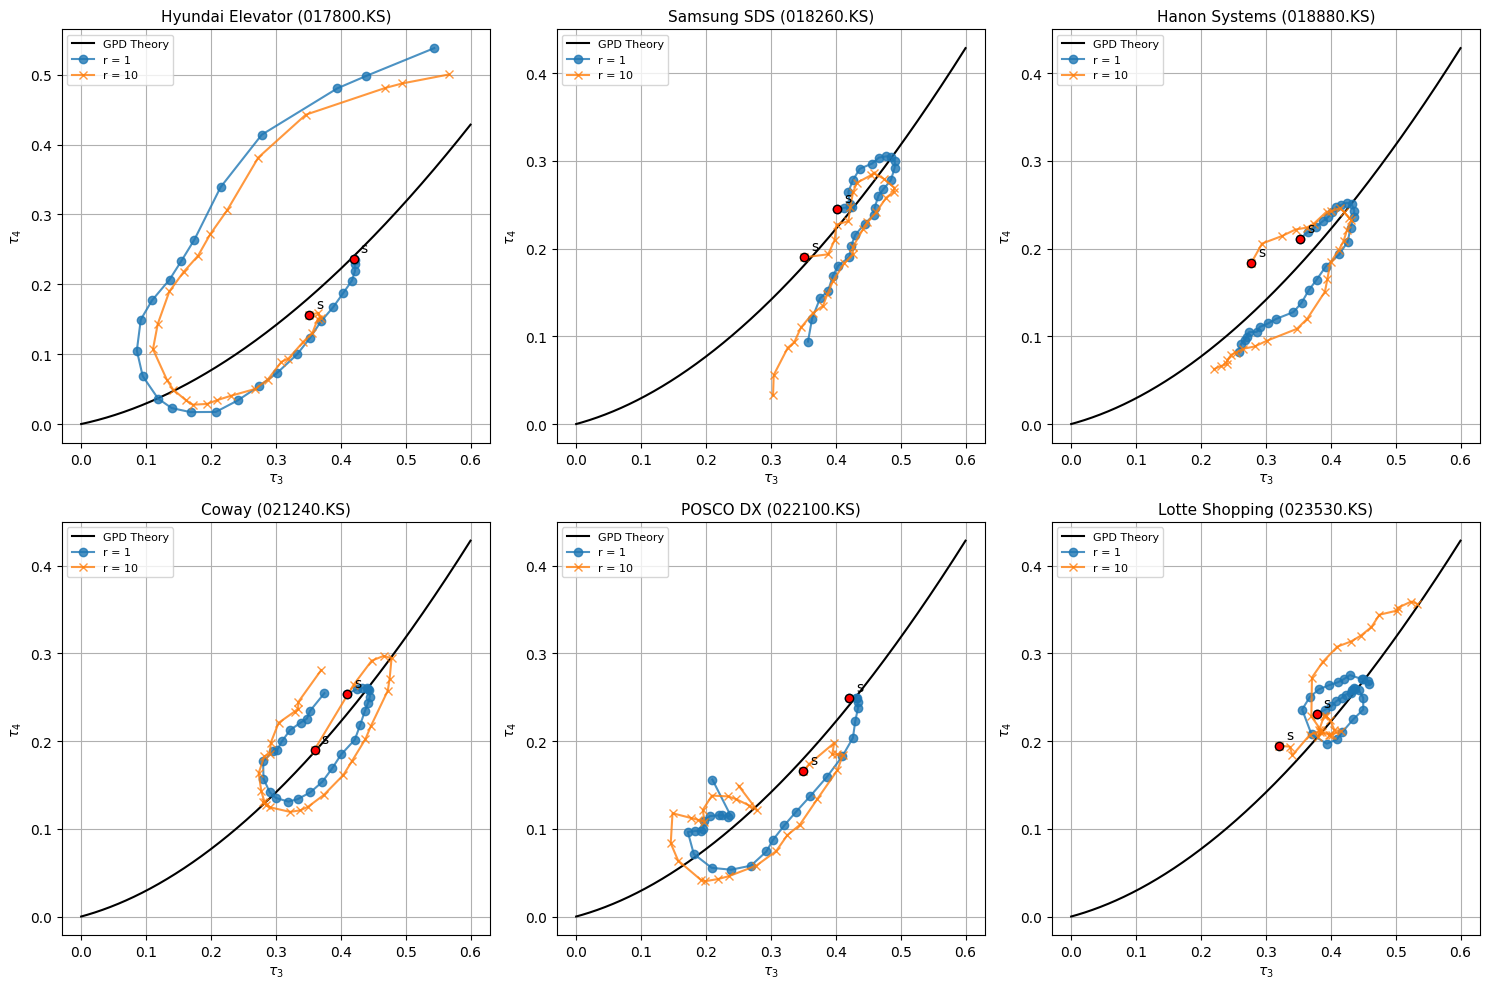

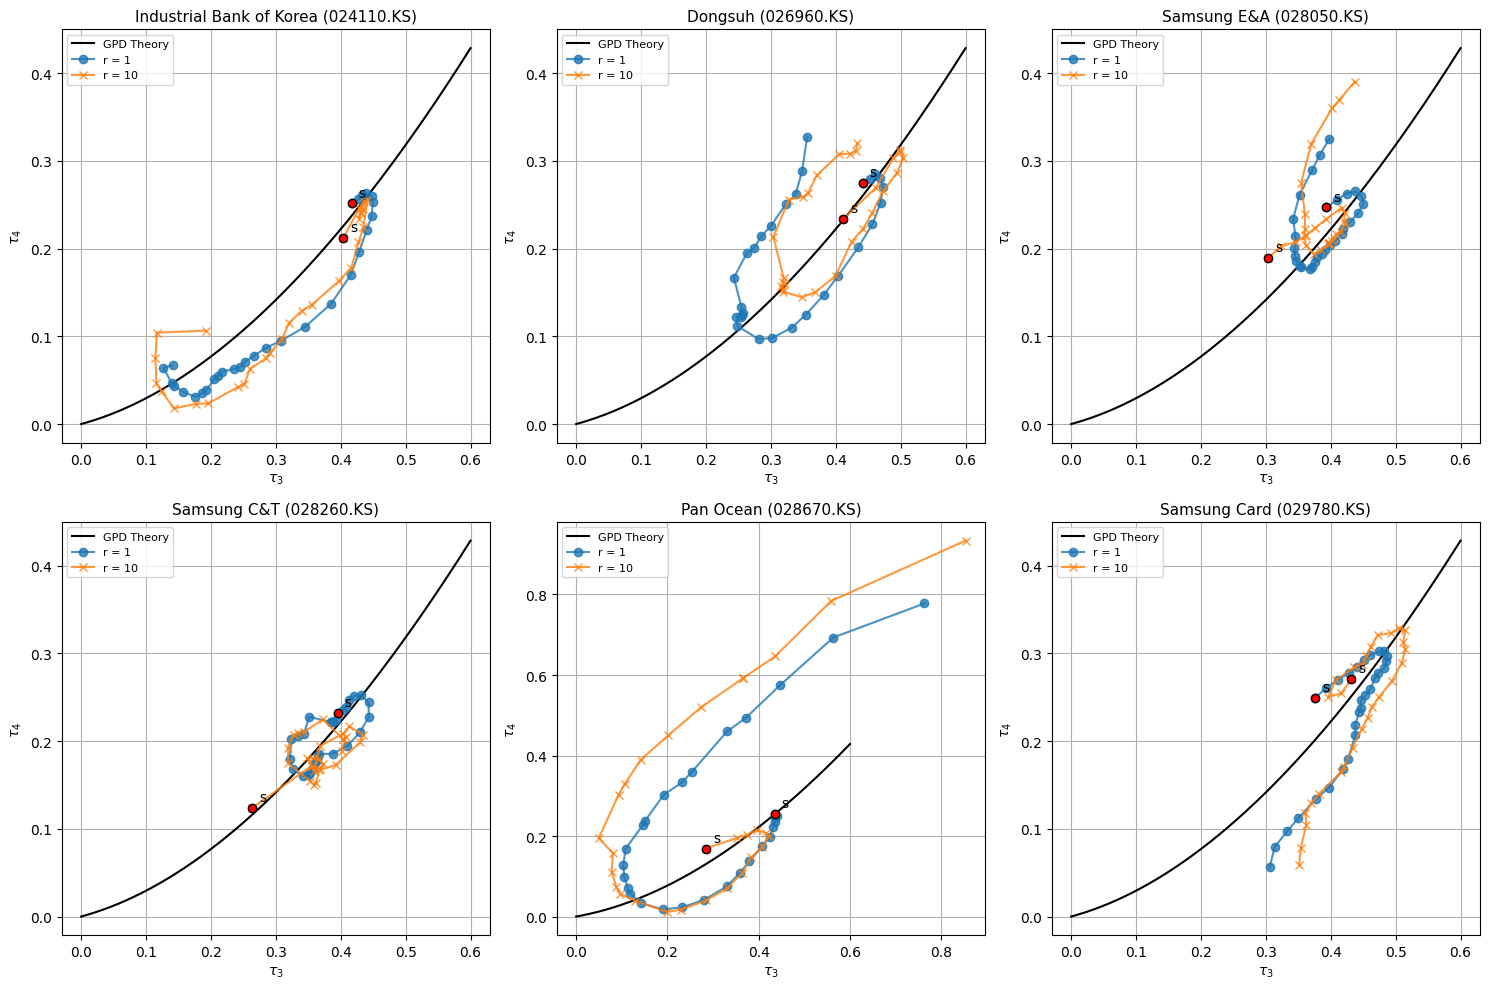

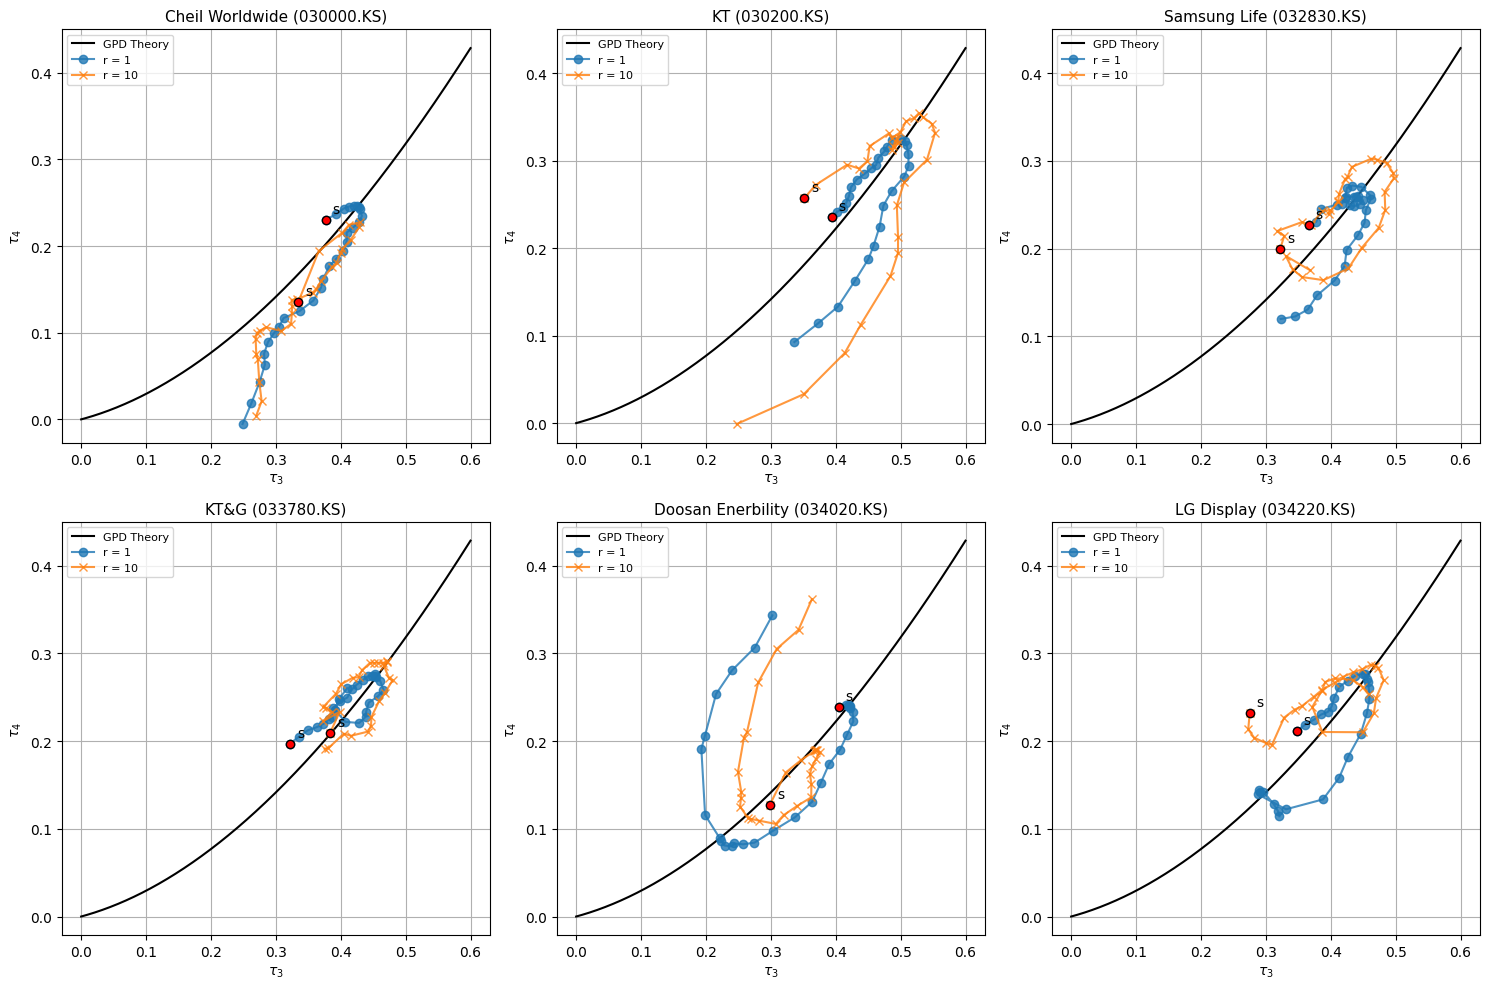

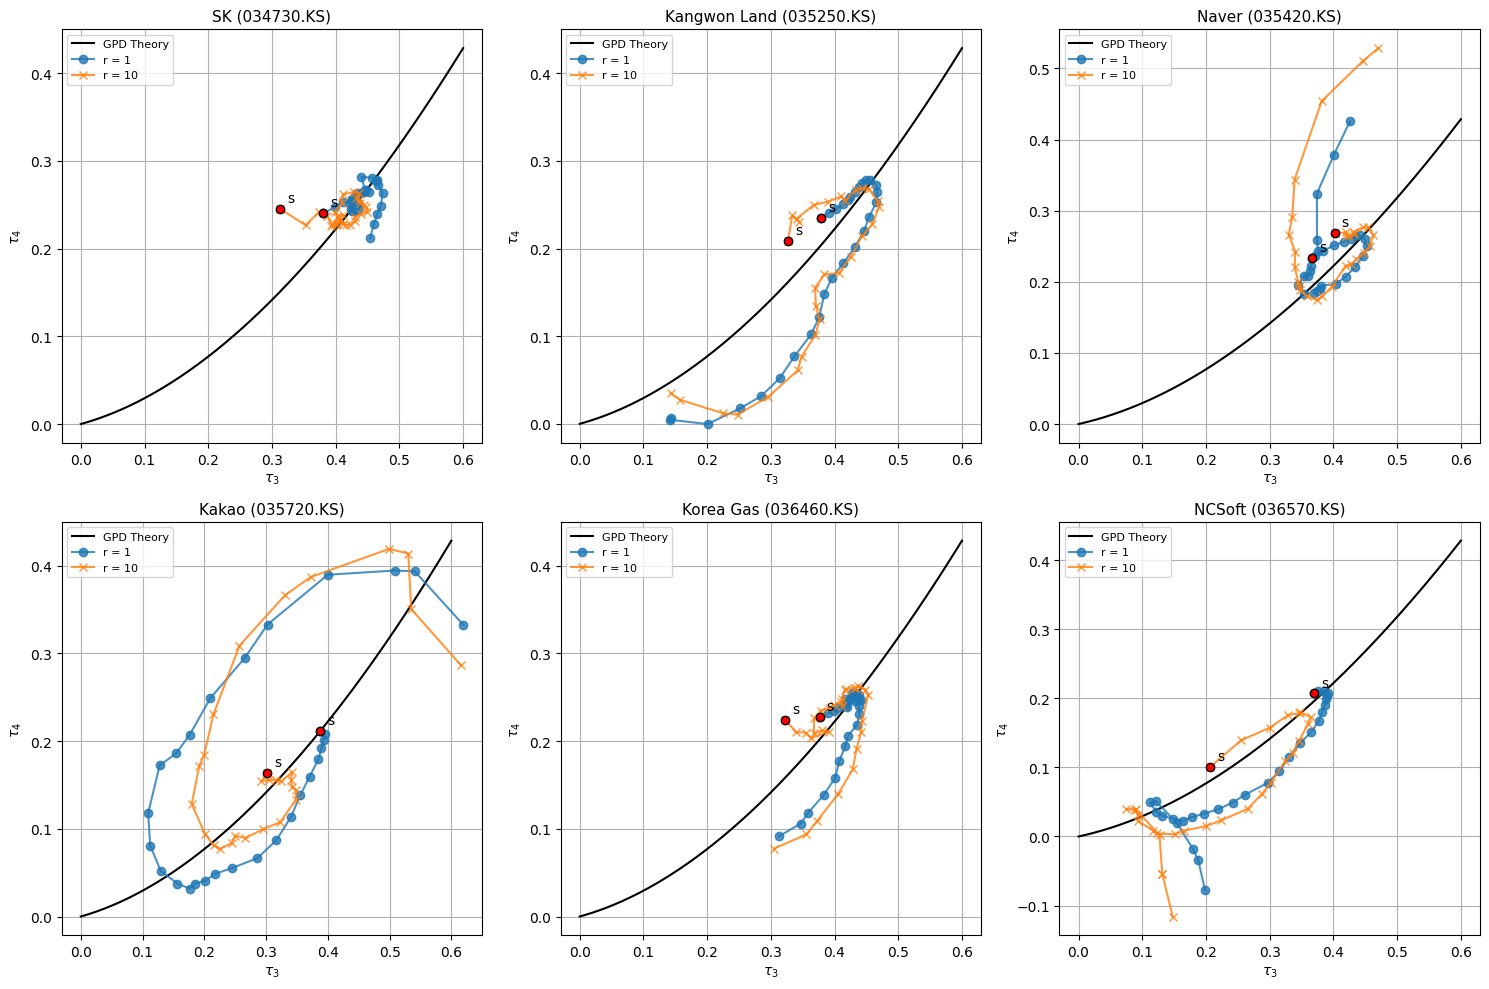

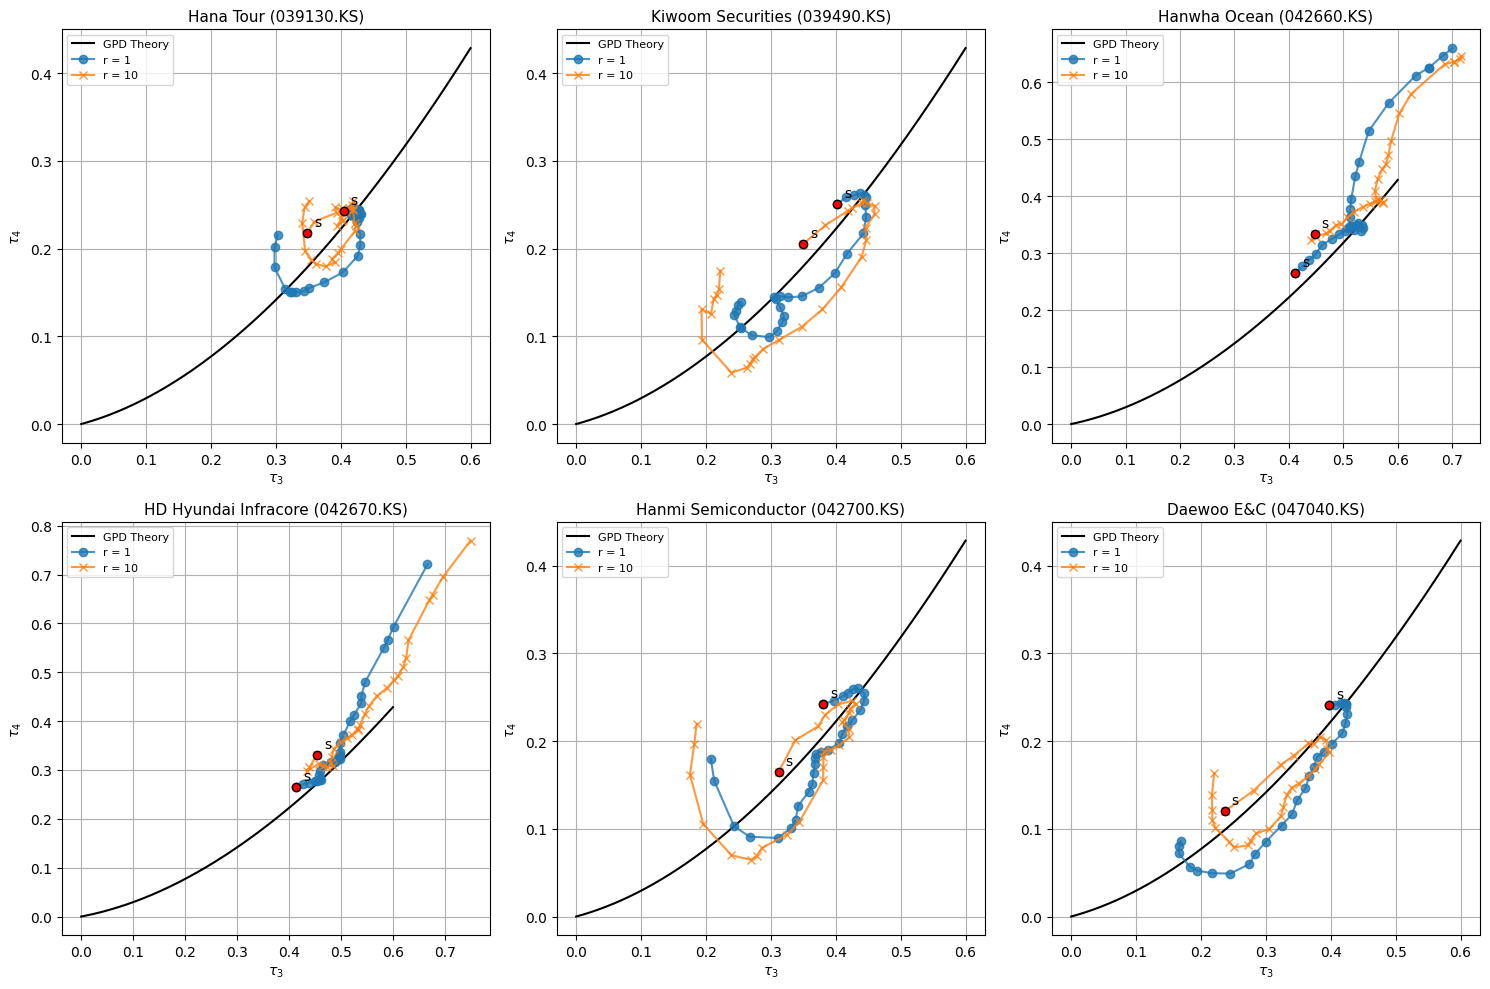

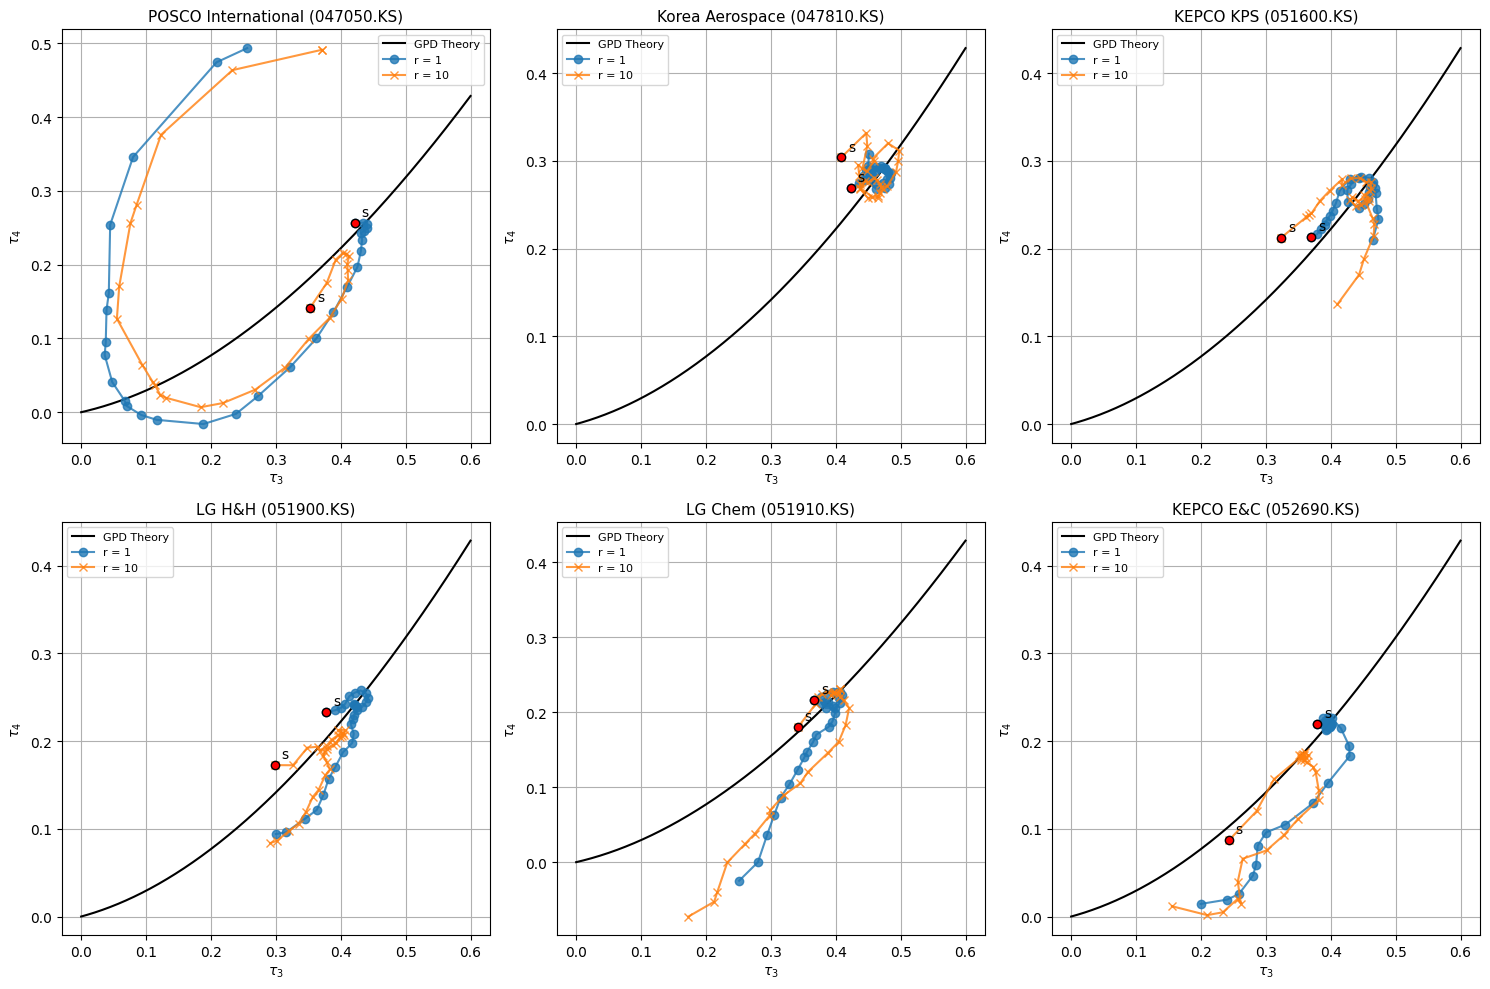

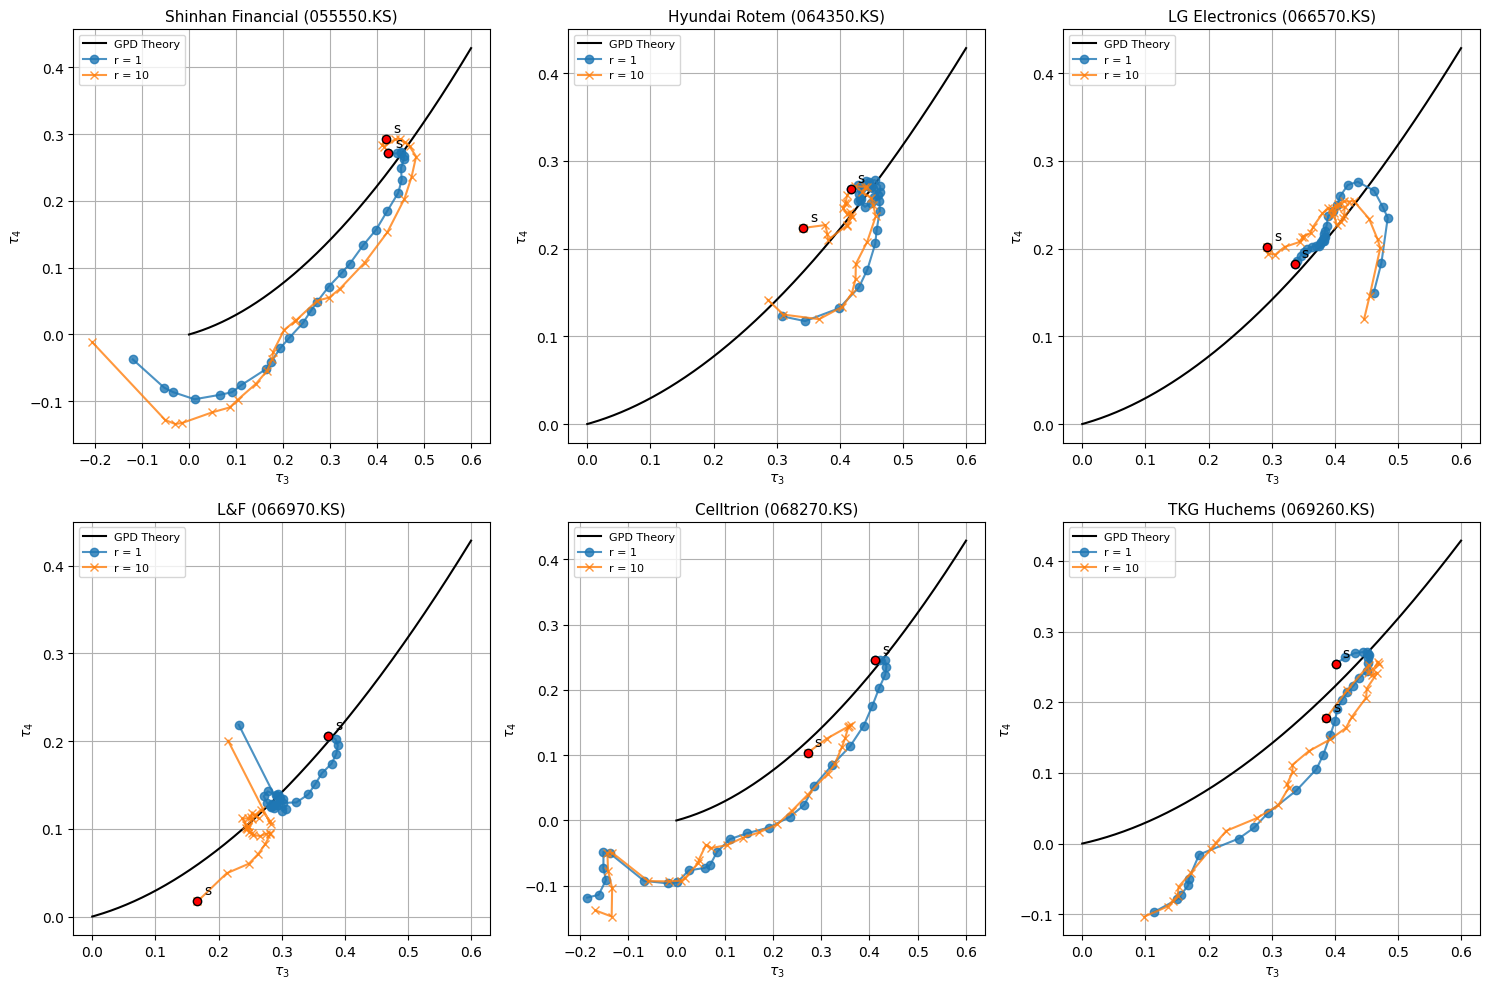

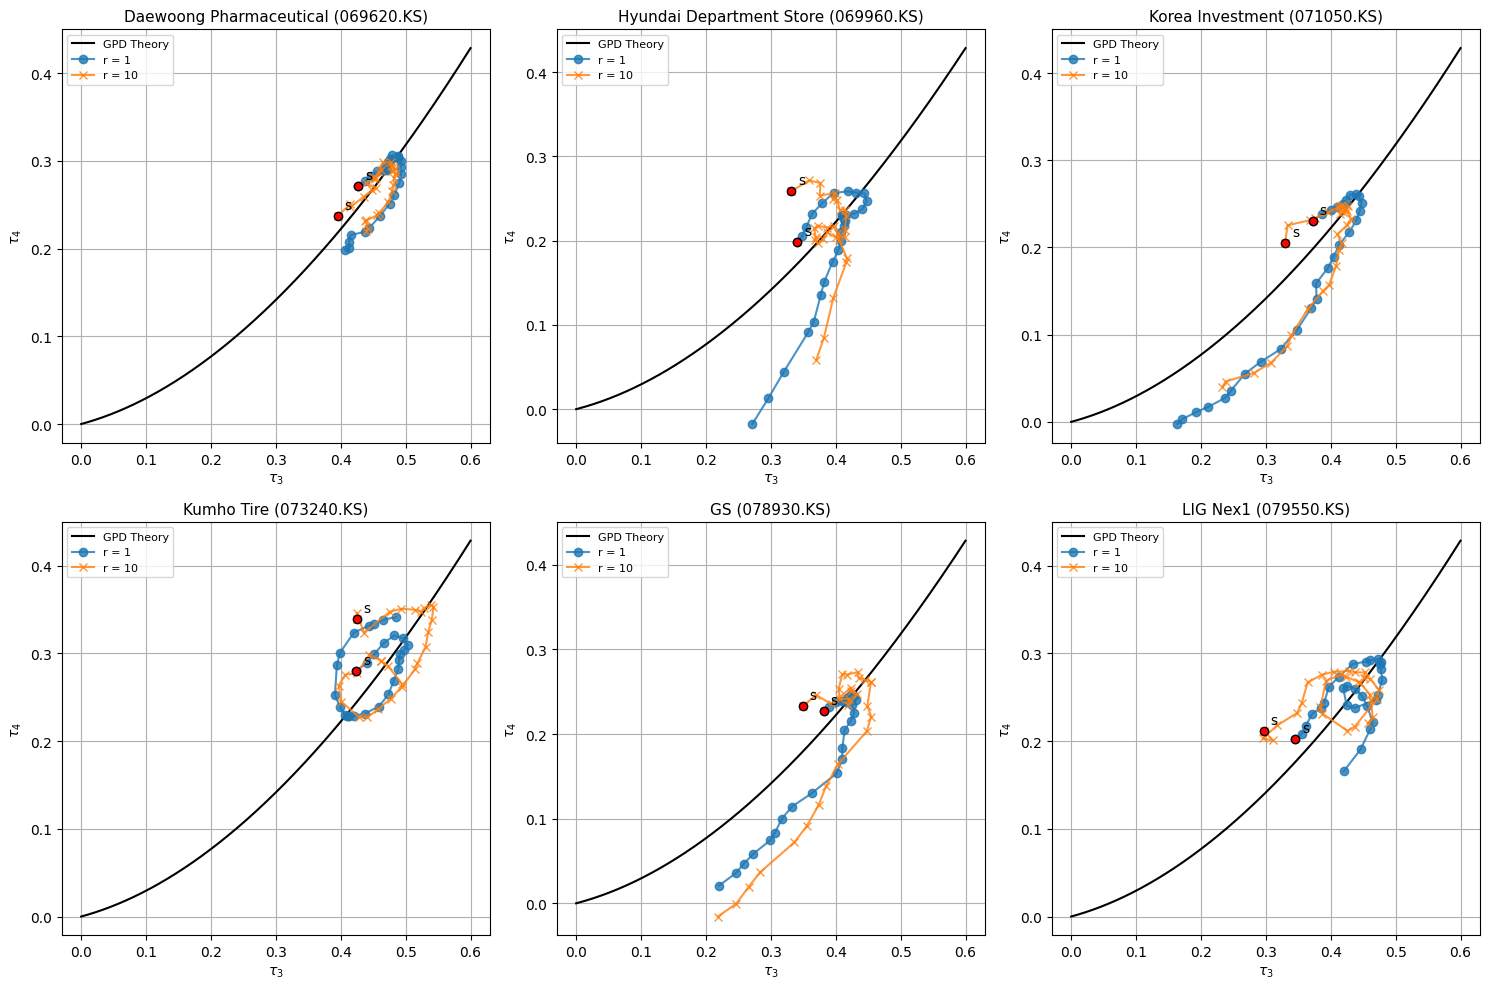

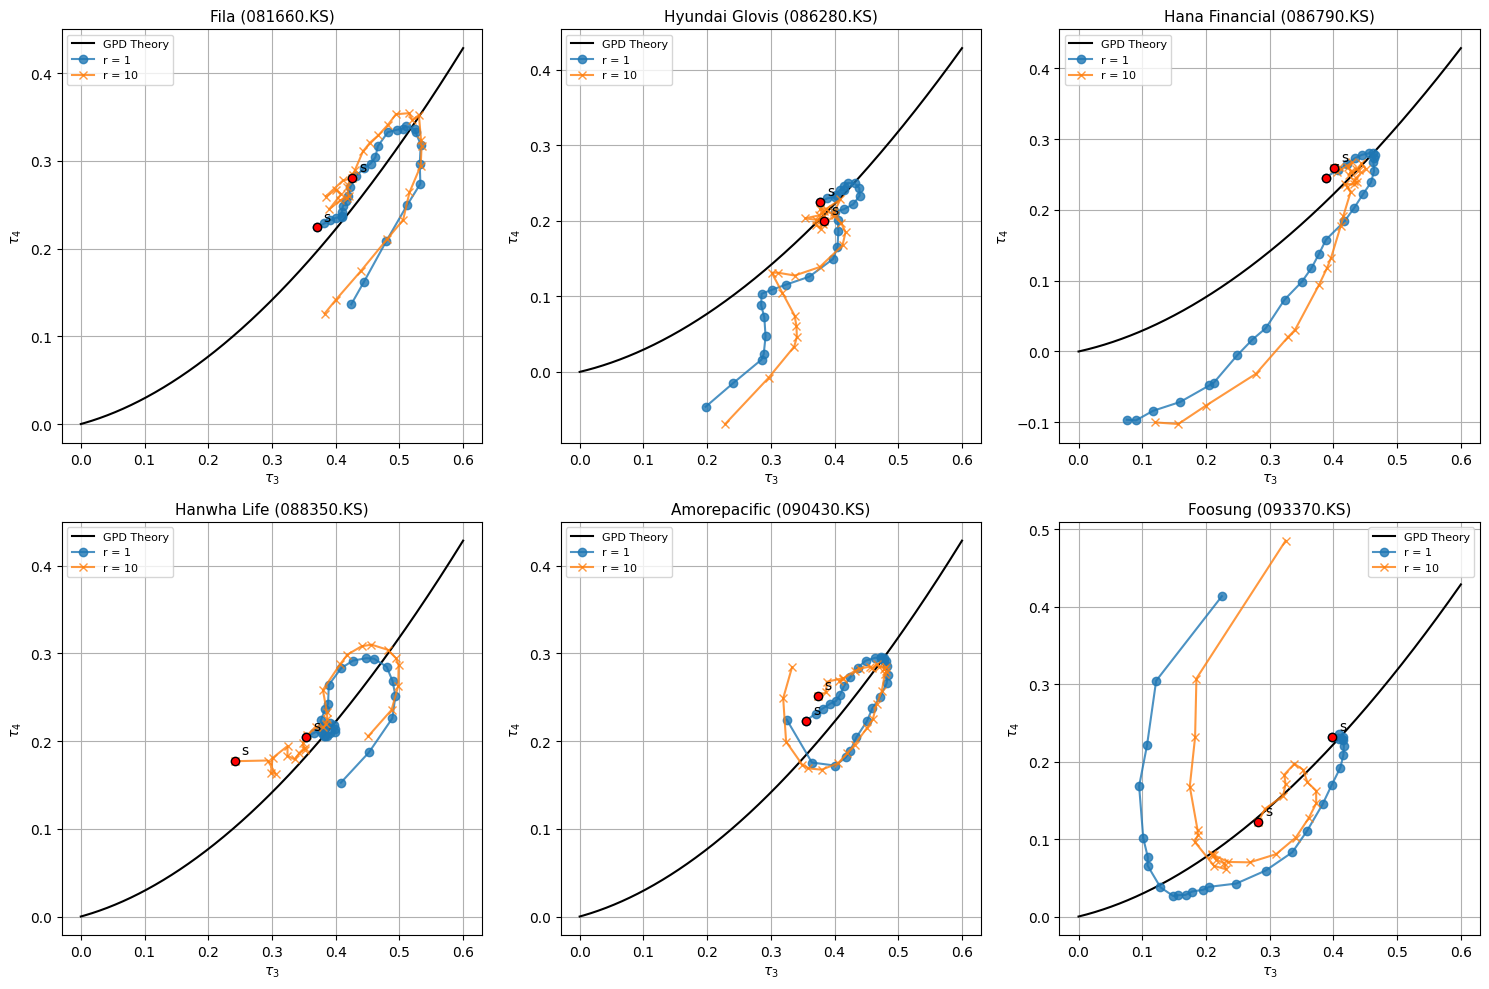

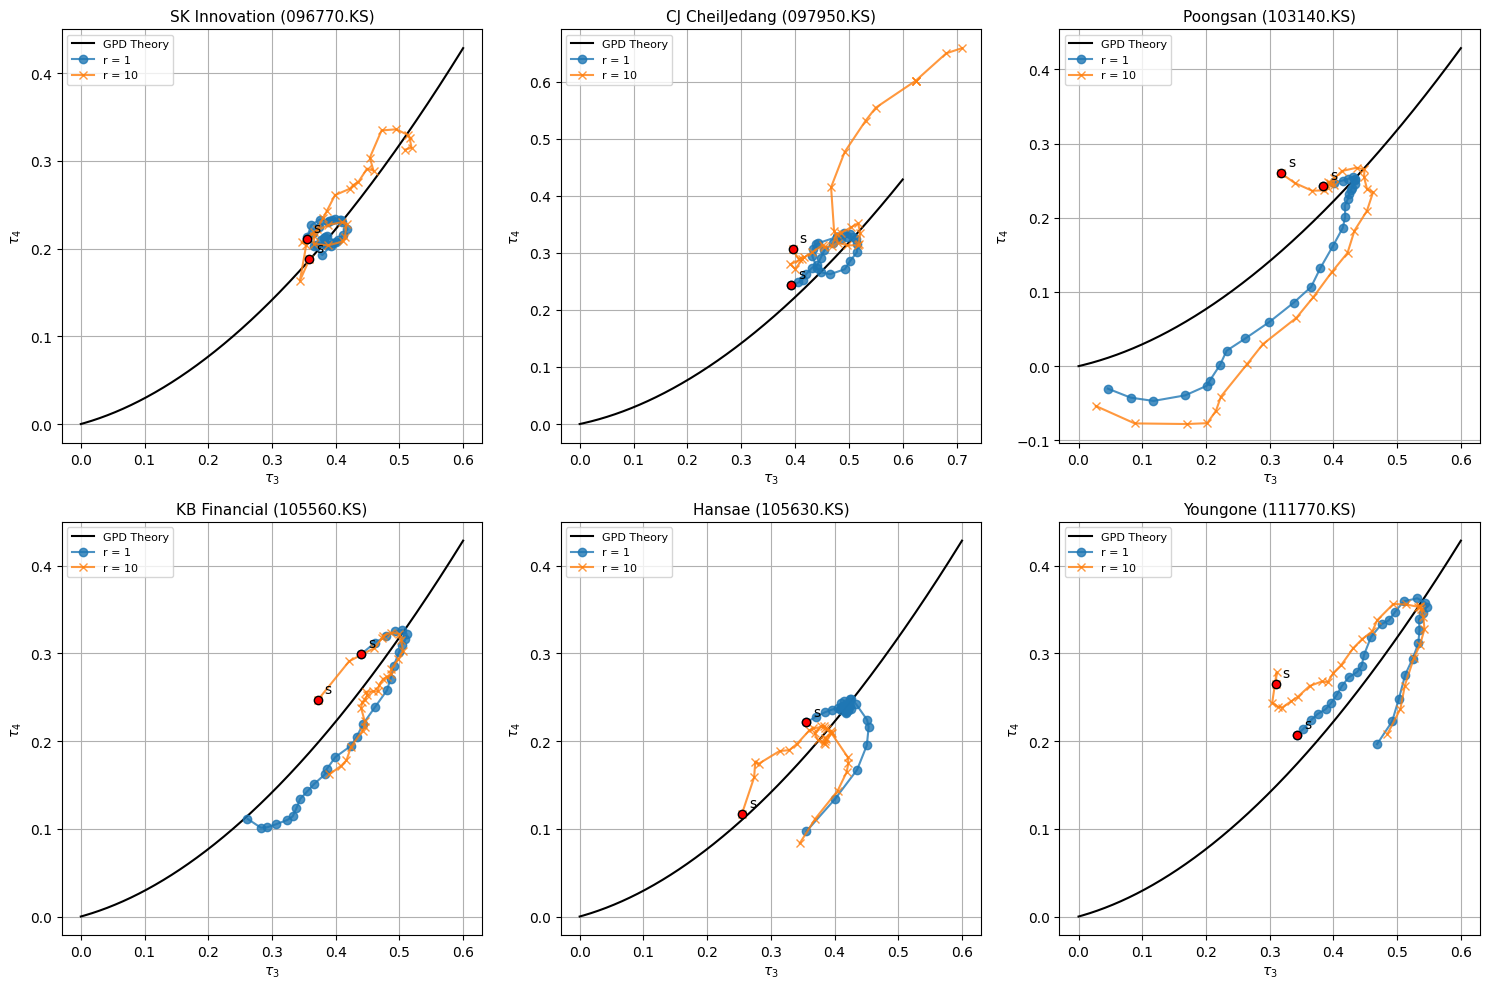

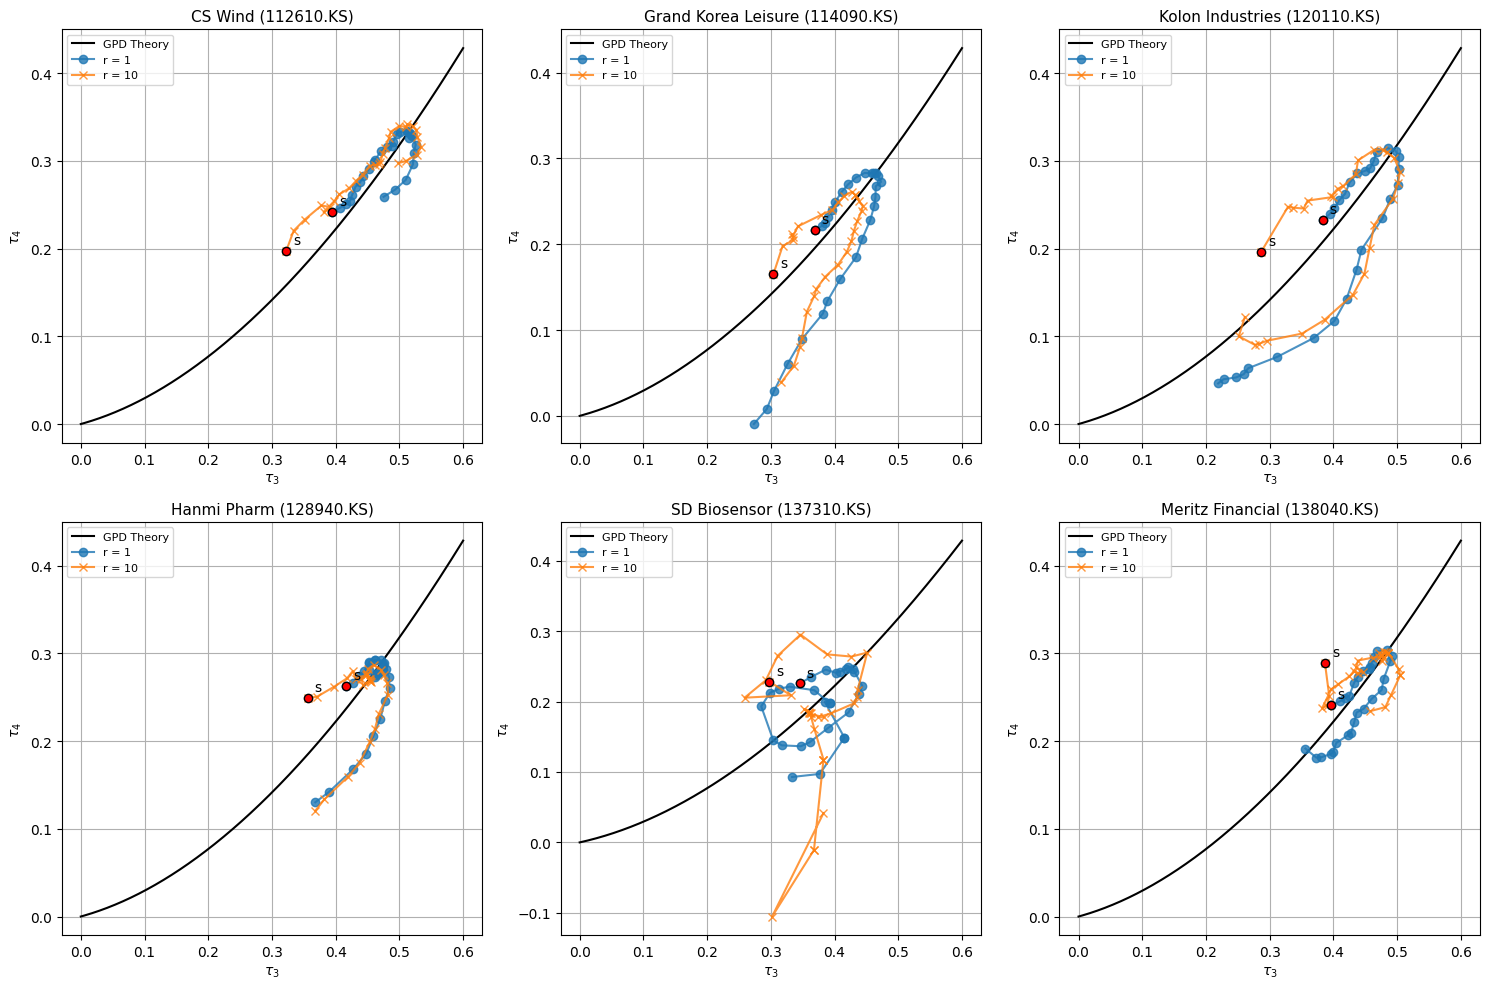

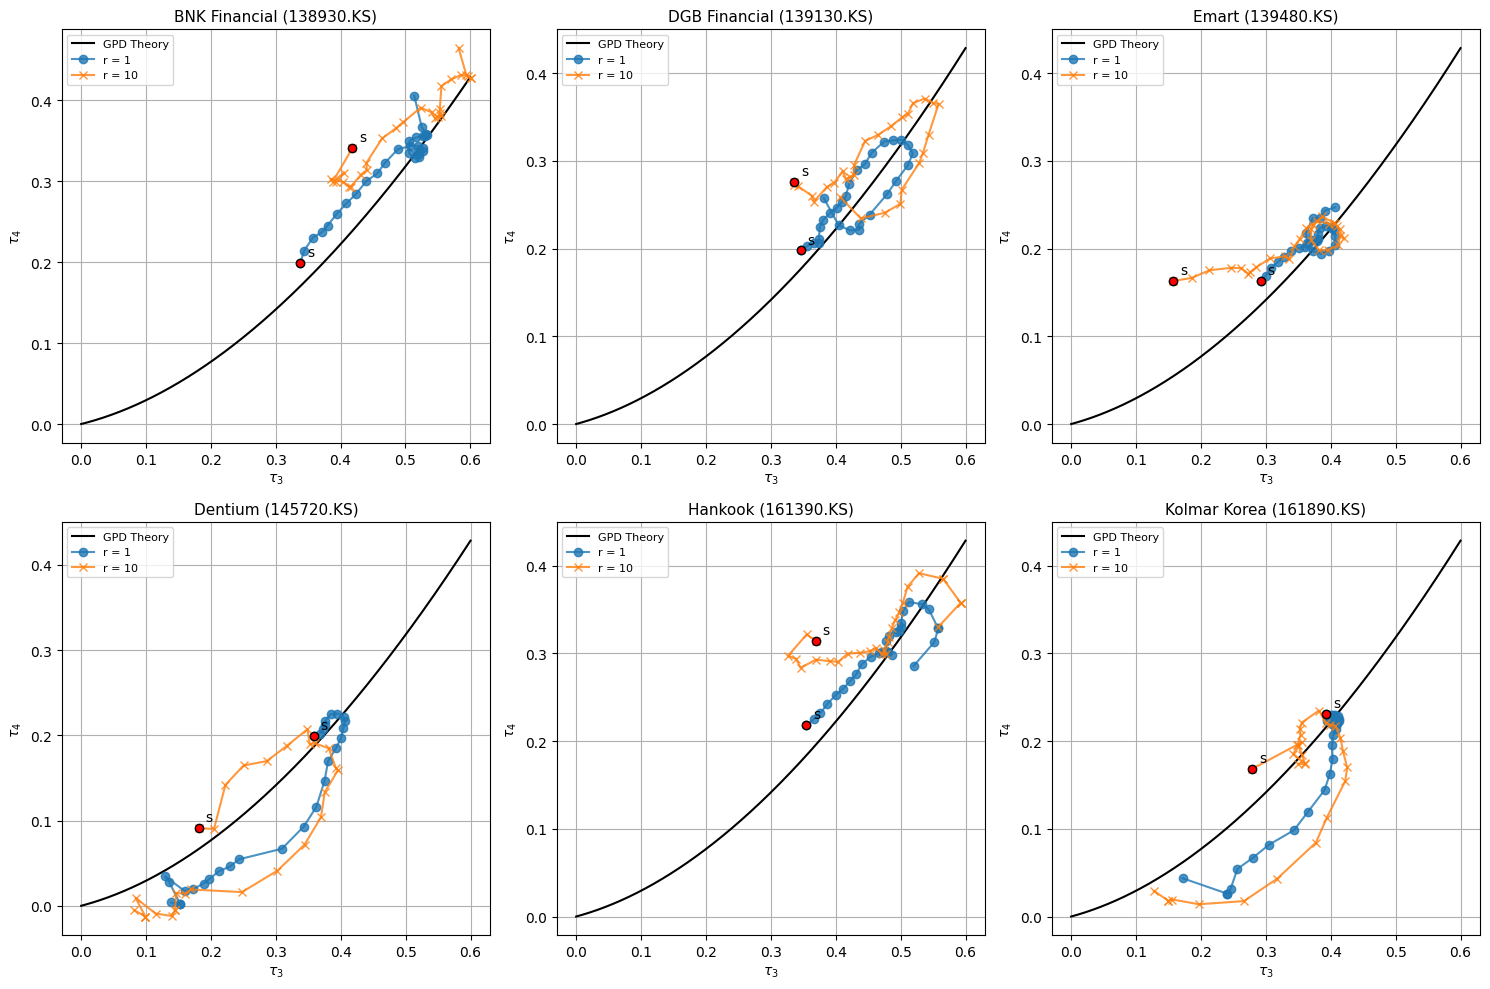

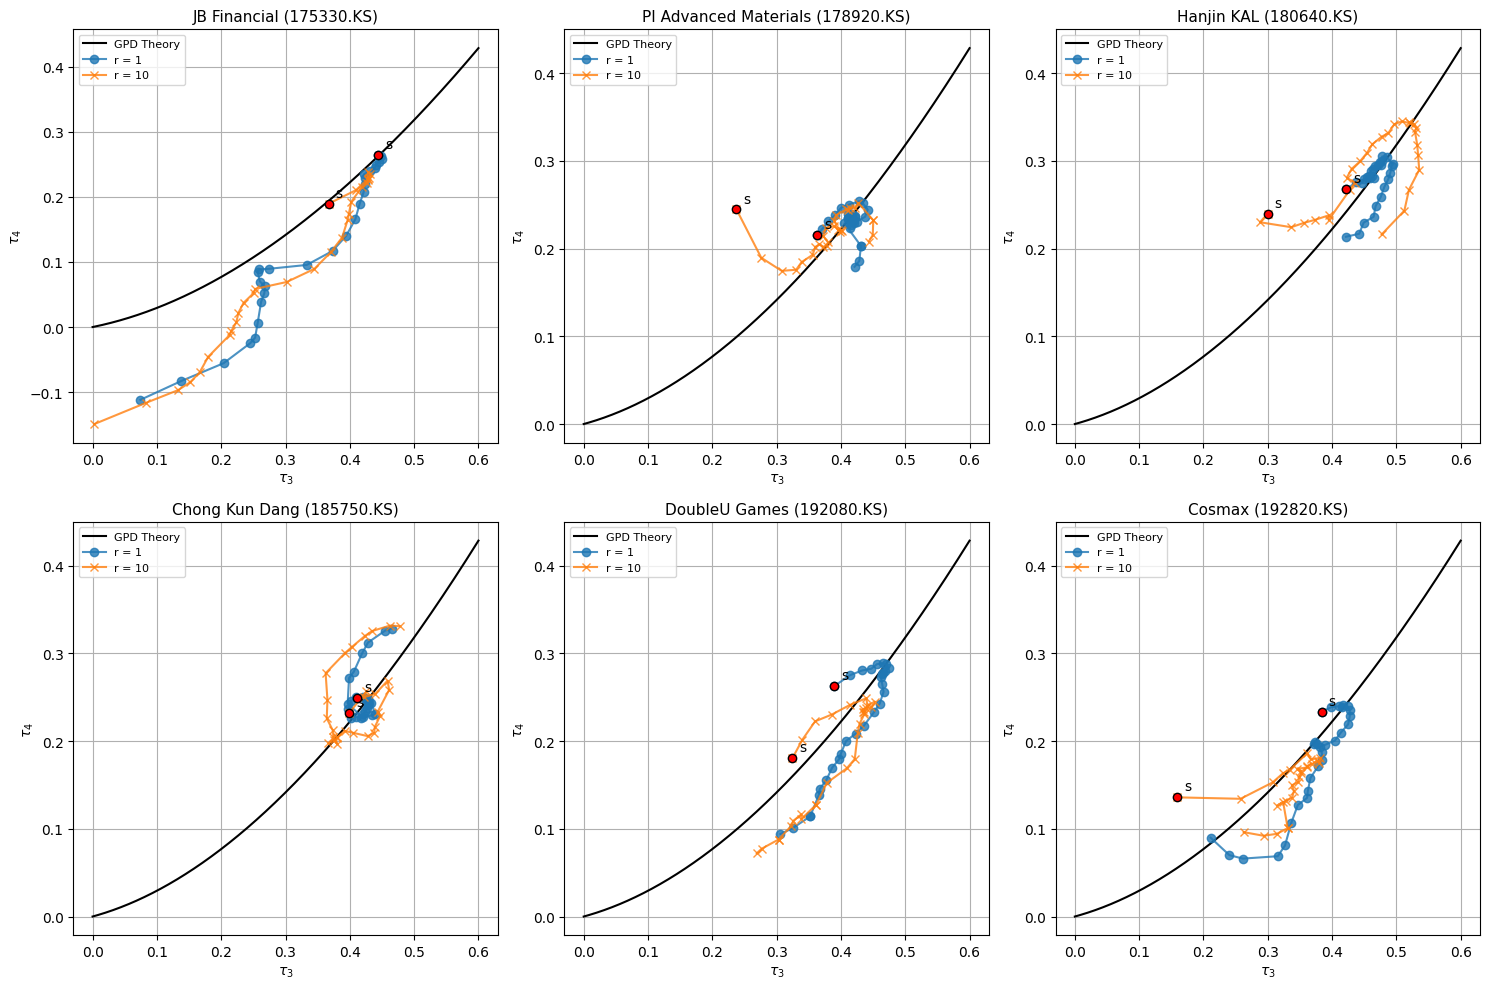

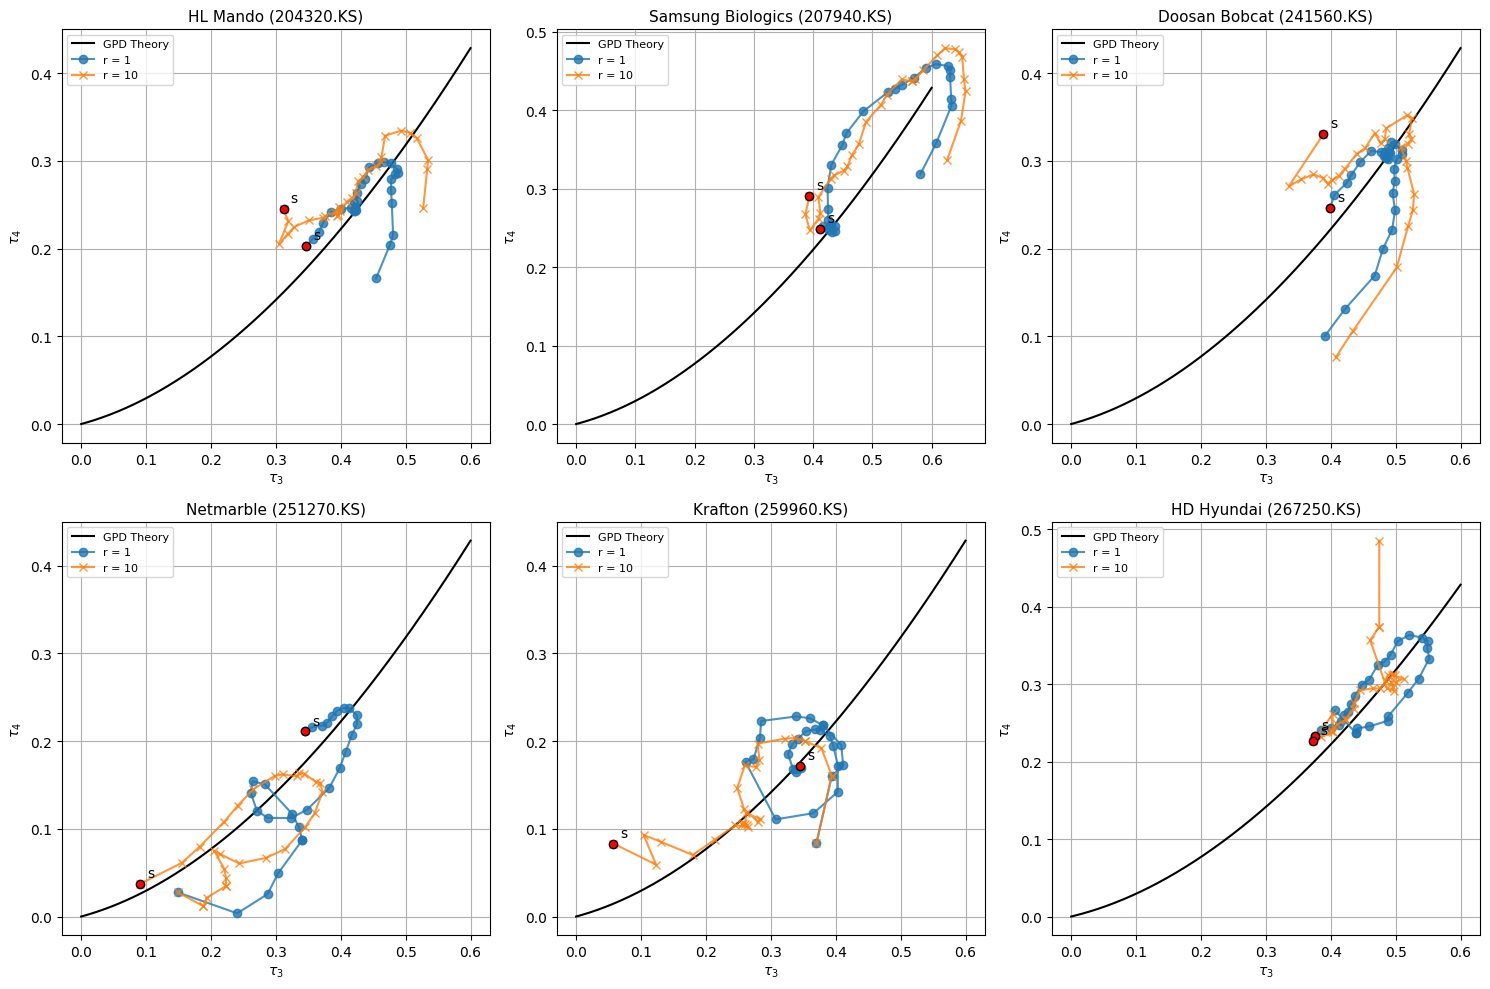

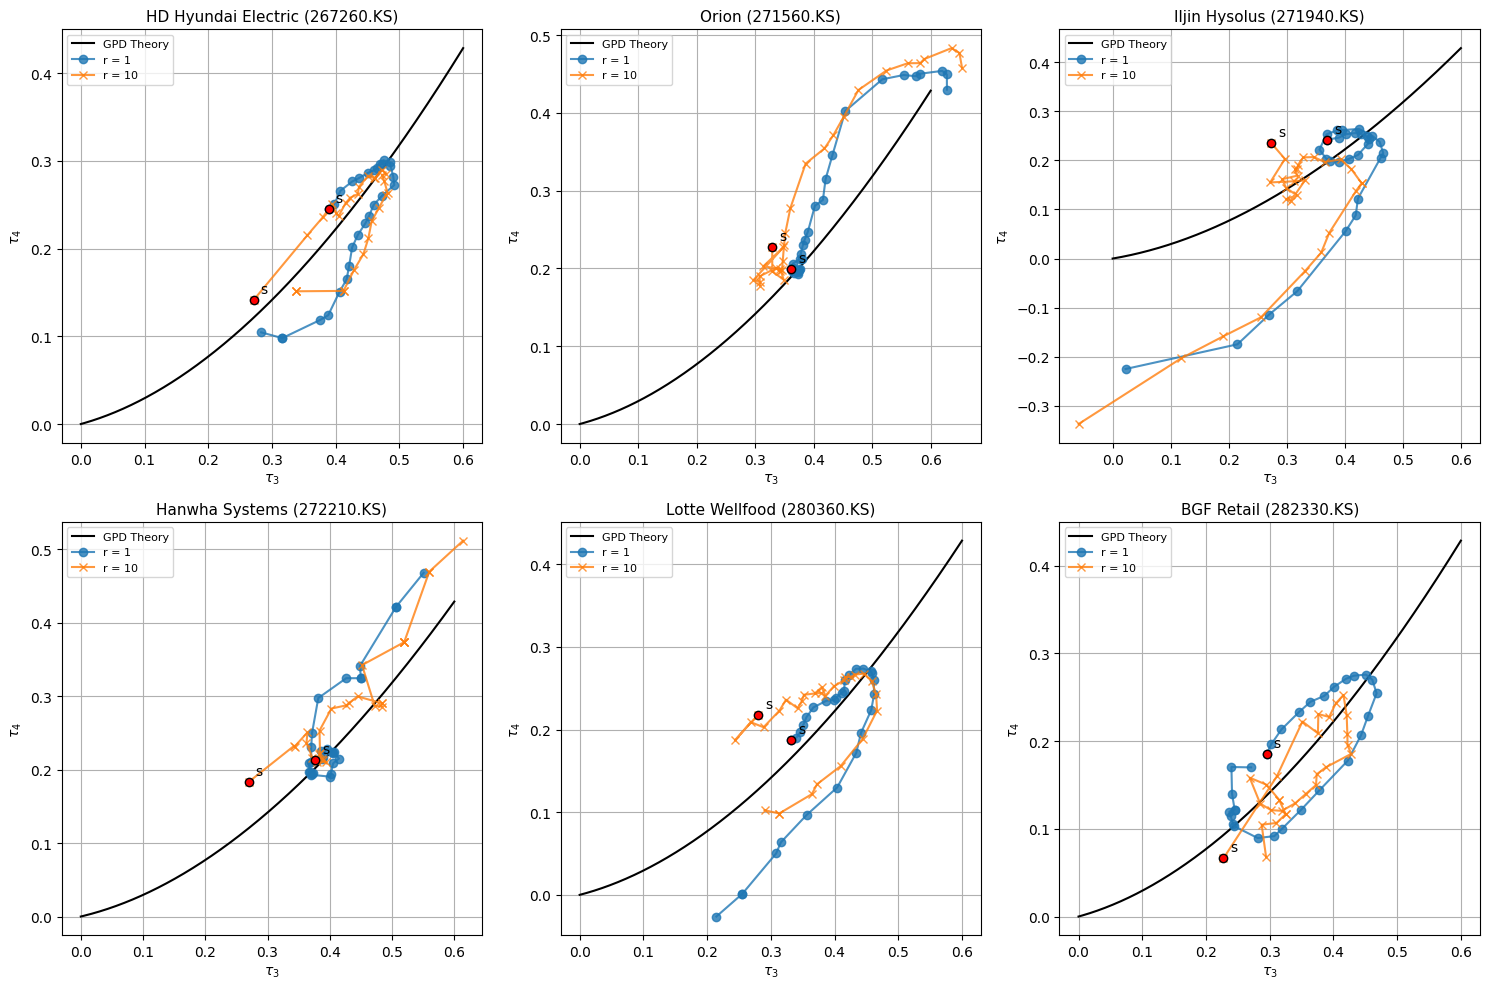

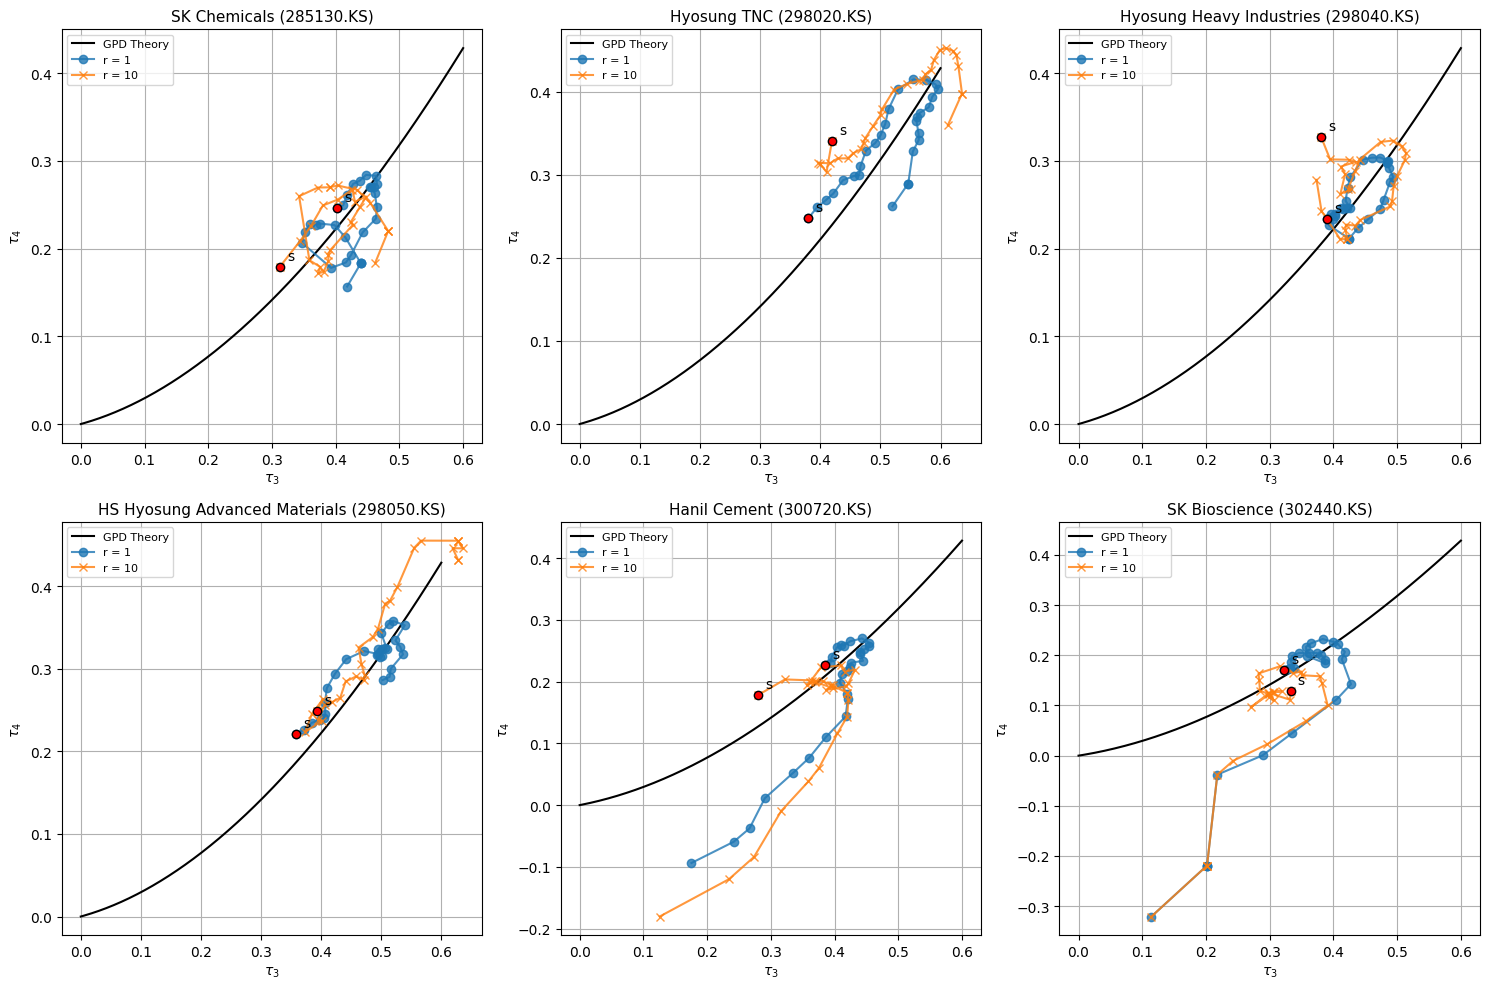

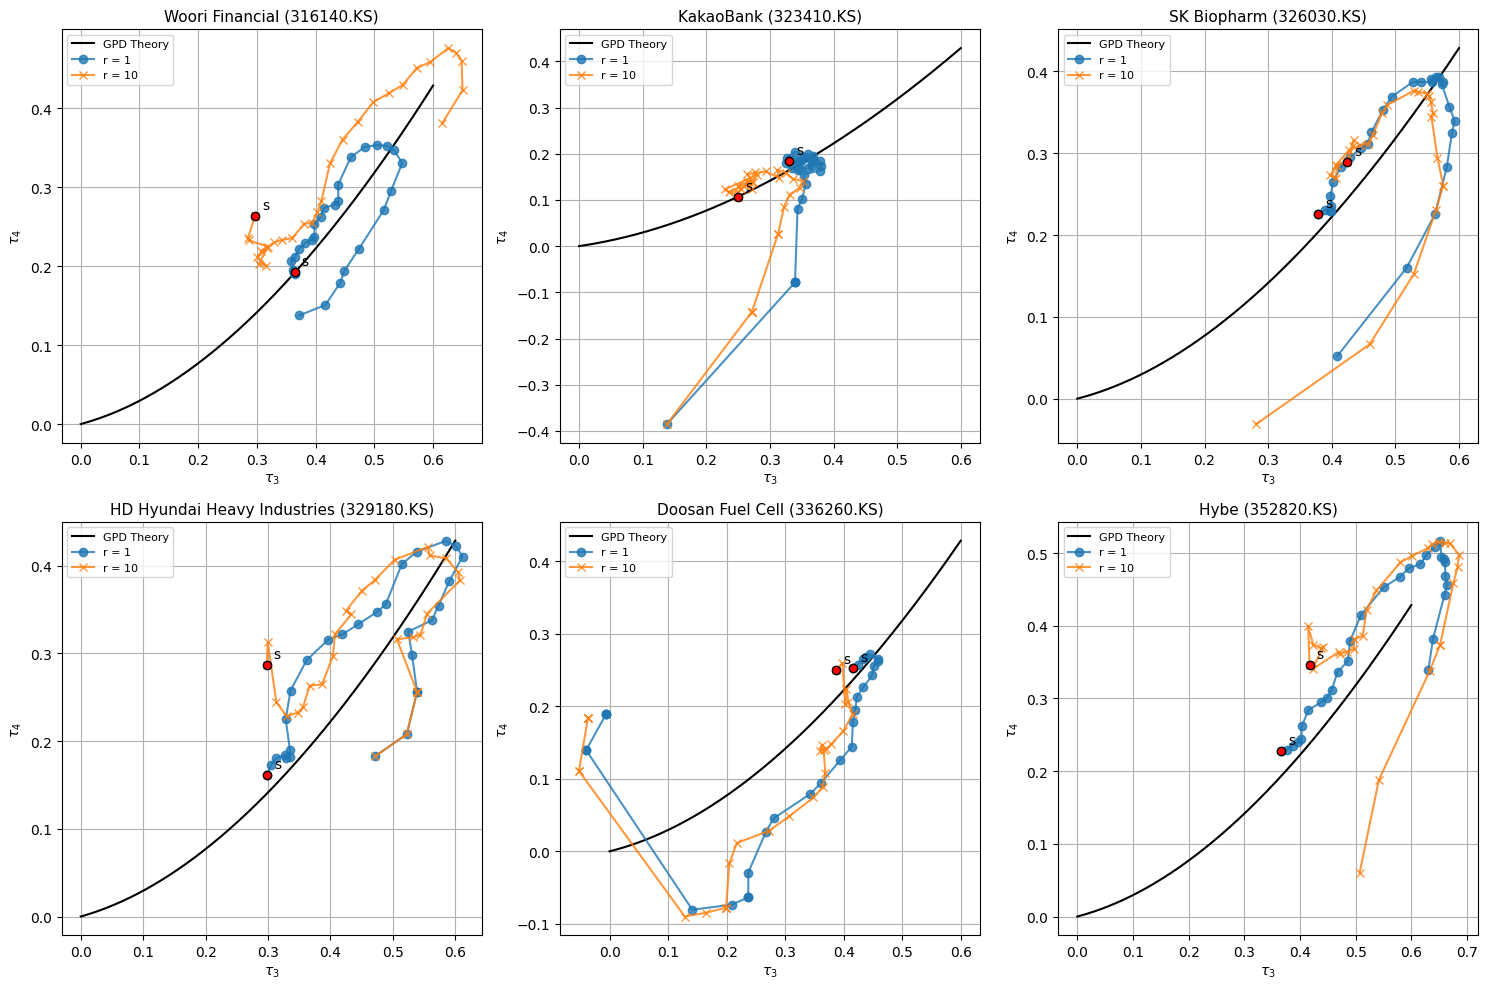

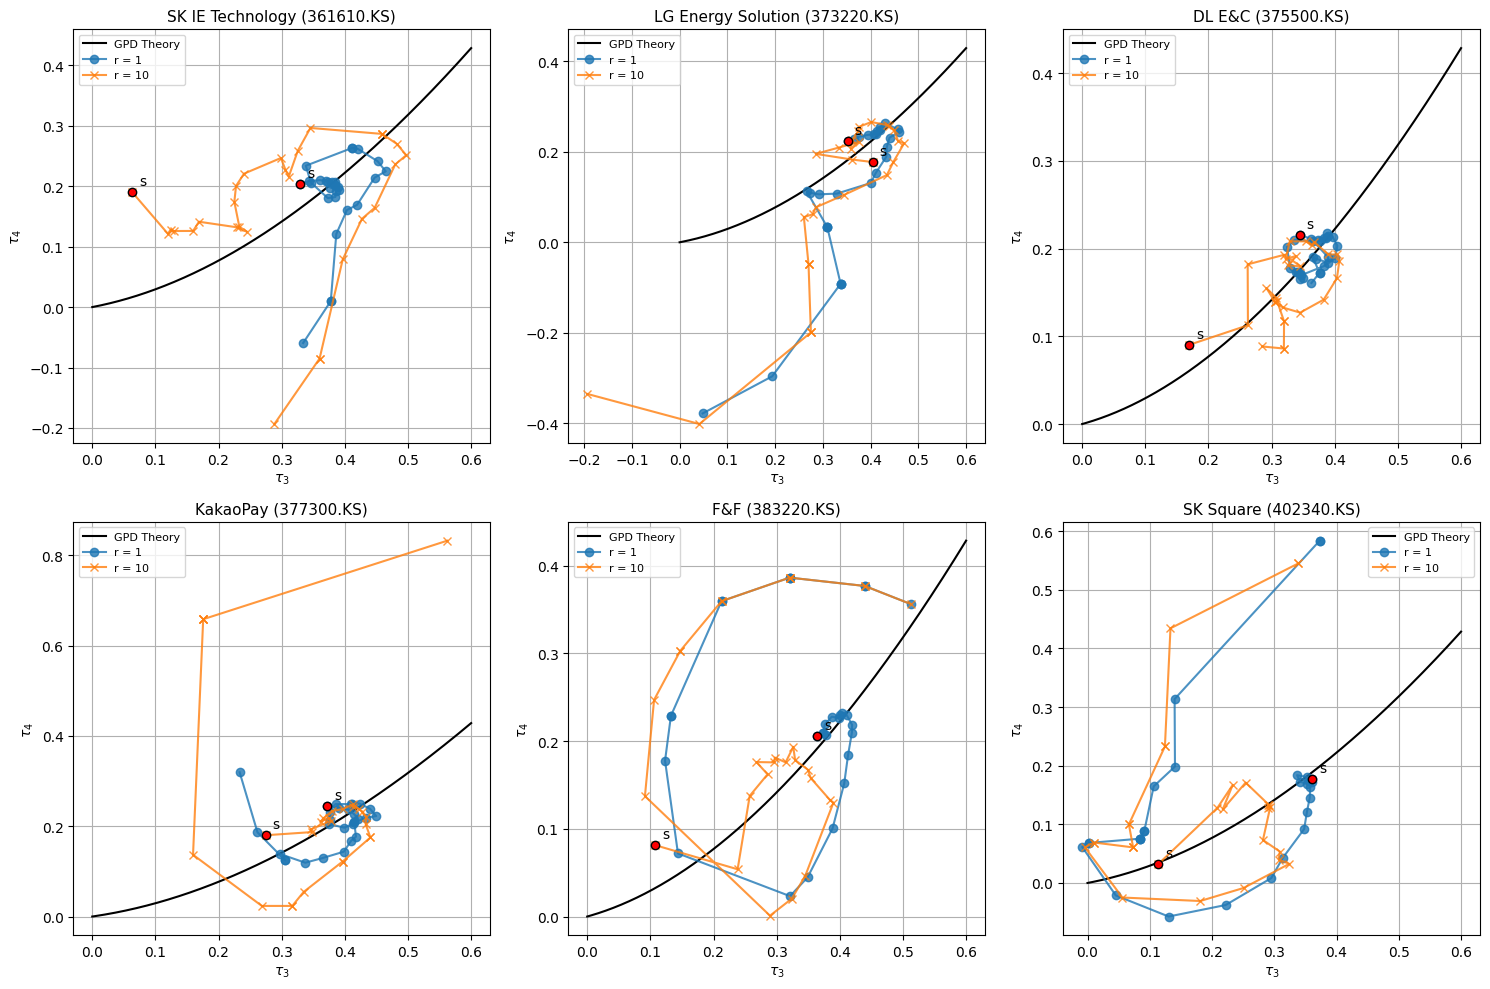

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import lmoments3 as lm
from pyextremes import get_extremes

# GPD 이론 곡선
xi_vals = np.linspace(-0.5, 1.0, 500)
tau3_theory = (1 - xi_vals) / (3 + xi_vals)
tau4_theory = (1 - xi_vals) * (2 - xi_vals) / ((3 + xi_vals) * (4 + xi_vals))

# 설정
r_range = [1, 10]
markers = ['o', 'x', '^', 'D', 'v', '*', 's', 'P']

tickers = logDD.columns

with PdfPages("hosking_diagrams_all.pdf") as pdf:
    for i in range(0, len(tickers), 6):
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        axes = axes.flatten()

        for j, ticker in enumerate(tickers[i:i+6]):
            ax = axes[j]
            series = logDD[ticker].dropna().sort_index()
            u_range = np.linspace(series.quantile(0.51), series.quantile(0.99), 29)

            # GPD 이론 곡선
            ax.plot(tau3_theory, tau4_theory, 'k-', label='GPD Theory')

            for idx, r in enumerate(r_range):
                tau3_list = []
                tau4_list = []

                for u in u_range:
                    excesses = get_extremes(series, method="POT", threshold=u, r=f"{r}d")
                    try:
                        lmr = lm.lmom_ratios(excesses, nmom=4)
                        tau3_list.append(lmr[2])
                        tau4_list.append(lmr[3])
                    except:
                        continue

                if tau3_list:
                    ax.plot(tau3_list, tau4_list,
                            marker=markers[idx % len(markers)],
                            linestyle='-', label=f'r = {r}', alpha=0.8)
                    ax.scatter(tau3_list[0], tau4_list[0],
                               color='red', edgecolor='black', zorder=5)
                    ax.annotate("s", (tau3_list[0], tau4_list[0]),
                                textcoords="offset points", xytext=(5, 5),
                                ha='left', fontsize=10)

            title = ticker_to_name.get(ticker, ticker)
            ax.set_title(f"{title} ({ticker})", fontsize=11)
            ax.set_xlabel(r'$\tau_3$')
            ax.set_ylabel(r'$\tau_4$')
            ax.grid(True)
            ax.legend(fontsize=8)

        # 남은 subplot 제거
        for k in range(j + 1, 6):
            fig.delaxes(axes[k])

        plt.tight_layout()
        plt.show()
        pdf.savefig(fig)
        plt.close(fig)